## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

# LABELS = [
#     "jalan_UL", "jalan_DR", "jalan_UR", "jalan_DL",
#     "sapu_UL", "sapu_DR", "sapu_UR", "sapu_DL",
#     # "barang_UL", "barang_DR", "barang_UR", "barang_DL",
#     # "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
#     "idle"
# ]

LABELS = [
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "barang2_DR", "barang2_UR", "barang2_DL", "barang2_UL",
    "barang1l_DR", "barang1l_UR", "barang1l_DL", "barang1l_UL",
    "barang1r_DR", "barang1r_UR", "barang1r_DL", "barang1r_UL",
    "idle_ND"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/Direct2a/Normalize/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

n_steps = 5
# n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print(training_data_count, test_data_count, n_input, n_classes)
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




5270 5270 36 17
(X shape, y shape, every X's mean, every X's standard deviation)
(5270, 5, 36) (5270, 1) 3.2492888e-09 27.20764

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

#     lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1], state_is_tuple=True)

#     lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden*2, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_3 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2, lstm_cell_3], state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(17,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560

# training_iters = training_data_count *512
# training_iters = training_data_count *1024
training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 6.186495, Accuracy = 0.03125
PERFORMANCE ON TEST SET:             Batch Loss = 5.33000373840332, Accuracy = 0.07096774131059647
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.673219, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 4.5144805908203125, Accuracy = 0.23567362129688263
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.246974, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 4.200148582458496, Accuracy = 0.25939279794692993
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 3.958392, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 3.902592182159424, Accuracy = 0.34459203481674194
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.753027, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 3.739433765411377, Accuracy = 0.38311195373535156
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 3.620198, Accuracy = 0.34375
PER

Iter #23040:  Learning rate = 0.005000:   Batch Loss = 2.243686, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 2.136462450027466, Accuracy = 0.7036052942276001
Iter #23552:  Learning rate = 0.005000:   Batch Loss = 2.131448, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.088813543319702, Accuracy = 0.7102466821670532
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 2.094801, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 2.0526373386383057, Accuracy = 0.7318785786628723
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 2.201949, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1693854331970215, Accuracy = 0.6855787634849548
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 2.218681, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 2.123366355895996, Accuracy = 0.6990512609481812
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 2.285961, Accuracy = 0.671875
PER

Iter #46592:  Learning rate = 0.005000:   Batch Loss = 1.591743, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7848858833312988, Accuracy = 0.7256166934967041
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 1.842180, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8331722021102905, Accuracy = 0.7091081738471985
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 1.612742, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.668548345565796, Accuracy = 0.7833017110824585
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 1.540449, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6282302141189575, Accuracy = 0.788994312286377
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 1.436139, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5740876197814941, Accuracy = 0.8051233291625977
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 1.474393, Accuracy = 0.8

Iter #69632:  Learning rate = 0.005000:   Batch Loss = 1.480275, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3948733806610107, Accuracy = 0.8172675371170044
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 1.543740, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.370741844177246, Accuracy = 0.8275142312049866
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 1.484109, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3912577629089355, Accuracy = 0.8273244500160217
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 1.371722, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.369666576385498, Accuracy = 0.826185941696167
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 1.307118, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3185063600540161, Accuracy = 0.8426945209503174
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 1.230822, Accuracy = 0.87

Iter #93184:  Learning rate = 0.005000:   Batch Loss = 0.951578, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.049957036972046, Accuracy = 0.9070208668708801
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 1.035320, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.053581714630127, Accuracy = 0.9024667739868164
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 1.018425, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0312199592590332, Accuracy = 0.9110056757926941
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 1.111892, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0493485927581787, Accuracy = 0.9026565551757812
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 1.005677, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0730178356170654, Accuracy = 0.8948766589164734
Iter #95744:  Learning rate = 0.005000:   Batch Loss = 1.023391, Accuracy = 0.92

Iter #116736:  Learning rate = 0.004800:   Batch Loss = 0.818812, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9647258520126343, Accuracy = 0.907400369644165
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 1.188017, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.066253662109375, Accuracy = 0.8618595600128174
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 1.087503, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9679204821586609, Accuracy = 0.9005692601203918
Iter #118272:  Learning rate = 0.004800:   Batch Loss = 0.928928, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9213579893112183, Accuracy = 0.9191650748252869
Iter #118784:  Learning rate = 0.004800:   Batch Loss = 0.926949, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9384671449661255, Accuracy = 0.9127134680747986
Iter #119296:  Learning rate = 0.004800:   Batch Loss = 0.897080, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.8091942667961121, Accuracy = 0.940986692905426
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 0.770210, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8483173847198486, Accuracy = 0.9216318726539612
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 0.784720, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8251187205314636, Accuracy = 0.9296014904975891
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 0.836489, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8366169929504395, Accuracy = 0.9233396649360657
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 0.915384, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8164103627204895, Accuracy = 0.9318785667419434
Iter #141824:  Learning rate = 0.004800:   Batch Loss = 0.836021, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8366423845291138, Acc

Iter #162816:  Learning rate = 0.004800:   Batch Loss = 0.786545, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7638958692550659, Accuracy = 0.9354838728904724
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 0.871375, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8110395669937134, Accuracy = 0.9098671674728394
Iter #163840:  Learning rate = 0.004800:   Batch Loss = 0.707204, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8068875074386597, Accuracy = 0.9210626482963562
Iter #164352:  Learning rate = 0.004800:   Batch Loss = 0.713705, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8051754236221313, Accuracy = 0.9201138615608215
Iter #164864:  Learning rate = 0.004800:   Batch Loss = 0.773912, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8499271869659424, Accuracy = 0.9018975496292114
Iter #165376:  Learning rate = 0.004800:   Batch Loss = 0.715575, Accurac

Iter #185856:  Learning rate = 0.004800:   Batch Loss = 0.818710, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8093175888061523, Accuracy = 0.9134724736213684
Iter #186368:  Learning rate = 0.004800:   Batch Loss = 0.759558, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7474429607391357, Accuracy = 0.9375711679458618
Iter #186880:  Learning rate = 0.004800:   Batch Loss = 0.847693, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7515199780464172, Accuracy = 0.9326375722885132
Iter #187392:  Learning rate = 0.004800:   Batch Loss = 0.816019, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7714256048202515, Accuracy = 0.9267551898956299
Iter #187904:  Learning rate = 0.004800:   Batch Loss = 0.804792, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7440696954727173, Accuracy = 0.9320682883262634
Iter #188416:  Learning rate = 0.004800:   Batch Loss = 0.666354, Accurac

Iter #209408:  Learning rate = 0.004608:   Batch Loss = 0.535981, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6404660940170288, Accuracy = 0.9620493650436401
Iter #209920:  Learning rate = 0.004608:   Batch Loss = 0.578369, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6340596079826355, Accuracy = 0.9603415727615356
Iter #210432:  Learning rate = 0.004608:   Batch Loss = 0.710313, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6322610378265381, Accuracy = 0.9612902998924255
Iter #210944:  Learning rate = 0.004608:   Batch Loss = 0.676960, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6461872458457947, Accuracy = 0.9552181959152222
Iter #211456:  Learning rate = 0.004608:   Batch Loss = 0.632650, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6325037479400635, Accuracy = 0.9601517915725708
Iter #211968:  Learning rate = 0.004608:   Batch Loss = 0.616034, Accuracy = 0

Iter #232960:  Learning rate = 0.004608:   Batch Loss = 0.580203, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6594179272651672, Accuracy = 0.9421252608299255
Iter #233472:  Learning rate = 0.004608:   Batch Loss = 0.719814, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6657538414001465, Accuracy = 0.9377608895301819
Iter #233984:  Learning rate = 0.004608:   Batch Loss = 0.686522, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6912959814071655, Accuracy = 0.9316887855529785
Iter #234496:  Learning rate = 0.004608:   Batch Loss = 0.793576, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6700462102890015, Accuracy = 0.940986692905426
Iter #235008:  Learning rate = 0.004608:   Batch Loss = 0.611166, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6882019639015198, Accuracy = 0.9307400584220886
Iter #235520:  Learning rate = 0.004608:   Batch Loss = 0.549620, Accuracy

Iter #256000:  Learning rate = 0.004608:   Batch Loss = 0.735595, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6005446910858154, Accuracy = 0.9544591903686523
Iter #256512:  Learning rate = 0.004608:   Batch Loss = 0.588089, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5991231203079224, Accuracy = 0.955977201461792
Iter #257024:  Learning rate = 0.004608:   Batch Loss = 0.621261, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5969787836074829, Accuracy = 0.9626185894012451
Iter #257536:  Learning rate = 0.004608:   Batch Loss = 0.658712, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6008400917053223, Accuracy = 0.9578747749328613
Iter #258048:  Learning rate = 0.004608:   Batch Loss = 0.621970, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5789249539375305, Accuracy = 0.966413676738739
Iter #258560:  Learning rate = 0.004608:   Batch Loss = 0.524896, Accuracy = 0

Iter #279552:  Learning rate = 0.004608:   Batch Loss = 0.580328, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6057401895523071, Accuracy = 0.9512333869934082
Iter #280064:  Learning rate = 0.004608:   Batch Loss = 0.586660, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5888358950614929, Accuracy = 0.9563567638397217
Iter #280576:  Learning rate = 0.004608:   Batch Loss = 0.631417, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6333491802215576, Accuracy = 0.9428842663764954
Iter #281088:  Learning rate = 0.004608:   Batch Loss = 0.648485, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6192964315414429, Accuracy = 0.9453510642051697
Iter #281600:  Learning rate = 0.004608:   Batch Loss = 0.609250, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5914538502693176, Accuracy = 0.9529411792755127
Iter #282112:  Learning rate = 0.004608:   Batch Loss = 0.588803, Accuracy 

Iter #303104:  Learning rate = 0.004424:   Batch Loss = 0.556187, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5299350023269653, Accuracy = 0.9719164967536926
Iter #303616:  Learning rate = 0.004424:   Batch Loss = 0.509840, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5329353213310242, Accuracy = 0.9722959995269775
Iter #304128:  Learning rate = 0.004424:   Batch Loss = 0.480713, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5030461549758911, Accuracy = 0.9804553985595703
Iter #304640:  Learning rate = 0.004424:   Batch Loss = 0.506805, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5048171877861023, Accuracy = 0.9783681035041809
Iter #305152:  Learning rate = 0.004424:   Batch Loss = 0.537018, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5077833533287048, Accuracy = 0.9732447862625122
Iter #305664:  Learning rate = 0.004424:   Batch Loss = 0.540442, Accu

Iter #326656:  Learning rate = 0.004424:   Batch Loss = 0.470202, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5248030424118042, Accuracy = 0.9667931795120239
Iter #327168:  Learning rate = 0.004424:   Batch Loss = 0.468884, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5405707359313965, Accuracy = 0.9590132832527161
Iter #327680:  Learning rate = 0.004424:   Batch Loss = 0.470927, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.619428813457489, Accuracy = 0.9303605556488037
Iter #328192:  Learning rate = 0.004424:   Batch Loss = 0.680288, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5896822810173035, Accuracy = 0.9447817802429199
Iter #328704:  Learning rate = 0.004424:   Batch Loss = 0.504058, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.572035551071167, Accuracy = 0.955407977104187
Iter #329216:  Learning rate = 0.004424:   Batch Loss = 0.684561, Accuracy = 0.92187

Iter #350208:  Learning rate = 0.004424:   Batch Loss = 0.504238, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5192415714263916, Accuracy = 0.9679316878318787
Iter #350720:  Learning rate = 0.004424:   Batch Loss = 0.449437, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5193853378295898, Accuracy = 0.9654648900032043
Iter #351232:  Learning rate = 0.004424:   Batch Loss = 0.472661, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5162176489830017, Accuracy = 0.9660341739654541
Iter #351744:  Learning rate = 0.004424:   Batch Loss = 0.536748, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5414704084396362, Accuracy = 0.9548386931419373
Iter #352256:  Learning rate = 0.004424:   Batch Loss = 0.539695, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5394620895385742, Accuracy = 0.955407977104187
Iter #352768:  Learning rate = 0.004424:   Batch Loss = 0.572413, Accurac

Iter #373760:  Learning rate = 0.004424:   Batch Loss = 0.479679, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4567859470844269, Accuracy = 0.9800758957862854
Iter #374272:  Learning rate = 0.004424:   Batch Loss = 0.505188, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48789817094802856, Accuracy = 0.966413676738739
Iter #374784:  Learning rate = 0.004424:   Batch Loss = 0.439047, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4663187563419342, Accuracy = 0.9732447862625122
Iter #375296:  Learning rate = 0.004424:   Batch Loss = 0.454427, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4711807370185852, Accuracy = 0.9711574912071228
Iter #375808:  Learning rate = 0.004424:   Batch Loss = 0.442575, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45920509099960327, Accuracy = 0.9772295951843262
Iter #376320:  Learning rate = 0.004424:   Batch Loss = 0.515724, Accura

Iter #397312:  Learning rate = 0.004424:   Batch Loss = 0.427563, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5029931664466858, Accuracy = 0.9609107971191406
Iter #397824:  Learning rate = 0.004424:   Batch Loss = 0.512286, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.48152589797973633, Accuracy = 0.9692599773406982
Iter #398336:  Learning rate = 0.004424:   Batch Loss = 0.472475, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4737202823162079, Accuracy = 0.9724857807159424
Iter #398848:  Learning rate = 0.004424:   Batch Loss = 0.435369, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.46802574396133423, Accuracy = 0.9711574912071228
Iter #399360:  Learning rate = 0.004424:   Batch Loss = 0.446301, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.50111985206604, Accuracy = 0.9612902998924255
Iter #399872:  Learning rate = 0.004424:   Batch Loss = 0.411016, Accuracy = 1.0
P

Iter #420864:  Learning rate = 0.004247:   Batch Loss = 0.417488, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41864609718322754, Accuracy = 0.9804553985595703
Iter #421376:  Learning rate = 0.004247:   Batch Loss = 0.411237, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42620280385017395, Accuracy = 0.9785578846931458
Iter #421888:  Learning rate = 0.004247:   Batch Loss = 0.374583, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41905277967453003, Accuracy = 0.9798861742019653
Iter #422400:  Learning rate = 0.004247:   Batch Loss = 0.376443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41753190755844116, Accuracy = 0.9838709831237793
Iter #422912:  Learning rate = 0.004247:   Batch Loss = 0.402532, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4247135519981384, Accuracy = 0.9785578846931458
Iter #423424:  Learning rate = 0.004247:   Batch Loss = 0.425336, Accuracy =

Iter #444416:  Learning rate = 0.004247:   Batch Loss = 0.584417, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4559241533279419, Accuracy = 0.9652751684188843
Iter #444928:  Learning rate = 0.004247:   Batch Loss = 0.405748, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43720248341560364, Accuracy = 0.9772295951843262
Iter #445440:  Learning rate = 0.004247:   Batch Loss = 0.448197, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4438115656375885, Accuracy = 0.9711574912071228
Iter #445952:  Learning rate = 0.004247:   Batch Loss = 0.399154, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4519980251789093, Accuracy = 0.9732447862625122
Iter #446464:  Learning rate = 0.004247:   Batch Loss = 0.538688, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4689450263977051, Accuracy = 0.9603415727615356
Iter #446976:  Learning rate = 0.004247:   Batch Loss = 0.479611, Accuracy

Iter #467968:  Learning rate = 0.004247:   Batch Loss = 0.375263, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4256865978240967, Accuracy = 0.9749525785446167
Iter #468480:  Learning rate = 0.004247:   Batch Loss = 0.439531, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4246848225593567, Accuracy = 0.9715369939804077
Iter #468992:  Learning rate = 0.004247:   Batch Loss = 0.377692, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.436544805765152, Accuracy = 0.9686906933784485
Iter #469504:  Learning rate = 0.004247:   Batch Loss = 0.474541, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4377918243408203, Accuracy = 0.9700189828872681
Iter #470016:  Learning rate = 0.004247:   Batch Loss = 0.408180, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4295978546142578, Accuracy = 0.9741935729980469
Iter #470528:  Learning rate = 0.004247:   Batch Loss = 0.389417, Accuracy = 0

Iter #491520:  Learning rate = 0.004247:   Batch Loss = 0.481031, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4036218225955963, Accuracy = 0.9795066118240356
Iter #492032:  Learning rate = 0.004247:   Batch Loss = 0.449036, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4146464467048645, Accuracy = 0.9722959995269775
Iter #492544:  Learning rate = 0.004247:   Batch Loss = 0.462752, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.42405611276626587, Accuracy = 0.970398485660553
Iter #493056:  Learning rate = 0.004247:   Batch Loss = 0.499186, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4652470350265503, Accuracy = 0.955977201461792
Iter #493568:  Learning rate = 0.004247:   Batch Loss = 0.410488, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43282246589660645, Accuracy = 0.9696394801139832
Iter #494080:  Learning rate = 0.004247:   Batch Loss = 0.550119, Accurac

Iter #515072:  Learning rate = 0.004077:   Batch Loss = 0.442091, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4518962800502777, Accuracy = 0.9603415727615356
Iter #515584:  Learning rate = 0.004077:   Batch Loss = 0.363836, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4434056282043457, Accuracy = 0.9650853872299194
Iter #516096:  Learning rate = 0.004077:   Batch Loss = 0.488571, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44055384397506714, Accuracy = 0.9648956060409546
Iter #516608:  Learning rate = 0.004077:   Batch Loss = 0.484228, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4329078495502472, Accuracy = 0.9679316878318787
Iter #517120:  Learning rate = 0.004077:   Batch Loss = 0.408775, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43242084980010986, Accuracy = 0.9715369939804077
Iter #517632:  Learning rate = 0.004077:   Batch Loss = 0.491974, Accuracy = 

Iter #538624:  Learning rate = 0.004077:   Batch Loss = 0.408092, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41286149621009827, Accuracy = 0.9688804745674133
Iter #539136:  Learning rate = 0.004077:   Batch Loss = 0.342966, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3893371522426605, Accuracy = 0.9806451797485352
Iter #539648:  Learning rate = 0.004077:   Batch Loss = 0.377198, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.40403056144714355, Accuracy = 0.974003791809082
Iter #540160:  Learning rate = 0.004077:   Batch Loss = 0.419703, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39375177025794983, Accuracy = 0.9777988791465759
Iter #540672:  Learning rate = 0.004077:   Batch Loss = 0.398860, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4110923409461975, Accuracy = 0.9671726822853088
Iter #541184:  Learning rate = 0.004077:   Batch Loss = 0.343027, Accuracy = 1.0


PERFORMANCE ON TEST SET:             Batch Loss = 0.38679081201553345, Accuracy = 0.9745730757713318
Iter #561664:  Learning rate = 0.004077:   Batch Loss = 0.338950, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3986232280731201, Accuracy = 0.9721062779426575
Iter #562176:  Learning rate = 0.004077:   Batch Loss = 0.363246, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37992891669273376, Accuracy = 0.9770398736000061
Iter #562688:  Learning rate = 0.004077:   Batch Loss = 0.356065, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37431854009628296, Accuracy = 0.9800758957862854
Iter #563200:  Learning rate = 0.004077:   Batch Loss = 0.378002, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3612145781517029, Accuracy = 0.9840607047080994
Iter #563712:  Learning rate = 0.004077:   Batch Loss = 0.358953, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3626747131347656, Accurac

Iter #584192:  Learning rate = 0.004077:   Batch Loss = 0.393222, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3895208537578583, Accuracy = 0.9783681035041809
Iter #584704:  Learning rate = 0.004077:   Batch Loss = 0.424322, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40663284063339233, Accuracy = 0.9721062779426575
Iter #585216:  Learning rate = 0.004077:   Batch Loss = 0.456303, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.38813233375549316, Accuracy = 0.9796963930130005
Iter #585728:  Learning rate = 0.004077:   Batch Loss = 0.354806, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4092760682106018, Accuracy = 0.9702087044715881
Iter #586240:  Learning rate = 0.004077:   Batch Loss = 0.340415, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3908326327800751, Accuracy = 0.9781783819198608
Iter #586752:  Learning rate = 0.004077:   Batch Loss = 0.326368, Accuracy = 1

Iter #607744:  Learning rate = 0.003914:   Batch Loss = 0.352447, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.34906327724456787, Accuracy = 0.985388994216919
Iter #608256:  Learning rate = 0.003914:   Batch Loss = 0.353756, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37848740816116333, Accuracy = 0.9745730757713318
Iter #608768:  Learning rate = 0.003914:   Batch Loss = 0.328320, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.35527303814888, Accuracy = 0.9831119775772095
Iter #609280:  Learning rate = 0.003914:   Batch Loss = 0.329180, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.34363871812820435, Accuracy = 0.985009491443634
Iter #609792:  Learning rate = 0.003914:   Batch Loss = 0.329287, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3593940734863281, Accuracy = 0.9833016991615295
Iter #610304:  Learning rate = 0.003914:   Batch Loss = 0.344025, Accuracy = 1.0
PERFO

Iter #631296:  Learning rate = 0.003914:   Batch Loss = 0.490101, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4285193681716919, Accuracy = 0.959392786026001
Iter #631808:  Learning rate = 0.003914:   Batch Loss = 0.469772, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4463680386543274, Accuracy = 0.9508538842201233
Iter #632320:  Learning rate = 0.003914:   Batch Loss = 0.466477, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4159545302391052, Accuracy = 0.9647058844566345
Iter #632832:  Learning rate = 0.003914:   Batch Loss = 0.407419, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.40733081102371216, Accuracy = 0.9652751684188843
Iter #633344:  Learning rate = 0.003914:   Batch Loss = 0.355160, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.39152753353118896, Accuracy = 0.9732447862625122
Iter #633856:  Learning rate = 0.003914:   Batch Loss = 0.446423, Accura

Iter #654848:  Learning rate = 0.003914:   Batch Loss = 0.314906, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33632734417915344, Accuracy = 0.9861479997634888
Iter #655360:  Learning rate = 0.003914:   Batch Loss = 0.334858, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3444575369358063, Accuracy = 0.9842504858970642
Iter #655872:  Learning rate = 0.003914:   Batch Loss = 0.314443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.332278311252594, Accuracy = 0.9891840815544128
Iter #656384:  Learning rate = 0.003914:   Batch Loss = 0.314471, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.33852866291999817, Accuracy = 0.9865275025367737
Iter #656896:  Learning rate = 0.003914:   Batch Loss = 0.299161, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32978594303131104, Accuracy = 0.9878557920455933
Iter #657408:  Learning rate = 0.003914:   Batch Loss = 0.322238, Accuracy = 0.96875

Iter #678400:  Learning rate = 0.003914:   Batch Loss = 0.357243, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3642757534980774, Accuracy = 0.9787476062774658
Iter #678912:  Learning rate = 0.003914:   Batch Loss = 0.366118, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3714170455932617, Accuracy = 0.9762808084487915
Iter #679424:  Learning rate = 0.003914:   Batch Loss = 0.313749, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3636440336704254, Accuracy = 0.9760910868644714
Iter #679936:  Learning rate = 0.003914:   Batch Loss = 0.330759, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3551981449127197, Accuracy = 0.98197340965271
Iter #680448:  Learning rate = 0.003914:   Batch Loss = 0.361085, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3576950132846832, Accuracy = 0.9759013056755066
Iter #680960:  Learning rate = 0.003914:   Batch Loss = 0.310831, Accura

Iter #700928:  Learning rate = 0.003757:   Batch Loss = 0.390760, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3725901246070862, Accuracy = 0.970588207244873
Iter #701440:  Learning rate = 0.003757:   Batch Loss = 0.436941, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3674015402793884, Accuracy = 0.974003791809082
Iter #701952:  Learning rate = 0.003757:   Batch Loss = 0.404603, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.38753950595855713, Accuracy = 0.970588207244873
Iter #702464:  Learning rate = 0.003757:   Batch Loss = 0.328688, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3717660903930664, Accuracy = 0.9719164967536926
Iter #702976:  Learning rate = 0.003757:   Batch Loss = 0.311730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36249205470085144, Accuracy = 0.9762808084487915
Iter #703488:  Learning rate = 0.003757:   Batch Loss = 0.367667, Accuracy = 0.96875


Iter #723968:  Learning rate = 0.003757:   Batch Loss = 0.328433, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.32525211572647095, Accuracy = 0.9817836880683899
Iter #724480:  Learning rate = 0.003757:   Batch Loss = 0.463622, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.31666404008865356, Accuracy = 0.985388994216919
Iter #724992:  Learning rate = 0.003757:   Batch Loss = 0.348065, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3307627737522125, Accuracy = 0.9810246825218201
Iter #725504:  Learning rate = 0.003757:   Batch Loss = 0.304970, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3558477759361267, Accuracy = 0.9679316878318787
Iter #726016:  Learning rate = 0.003757:   Batch Loss = 0.297785, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3268776535987854, Accuracy = 0.9859582781791687
Iter #726528:  Learning rate = 0.003757:   Batch Loss = 0.283393, Accur

Iter #746496:  Learning rate = 0.003757:   Batch Loss = 0.407776, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3358401656150818, Accuracy = 0.9793168902397156
Iter #747008:  Learning rate = 0.003757:   Batch Loss = 0.314713, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3353404402732849, Accuracy = 0.9812144041061401
Iter #747520:  Learning rate = 0.003757:   Batch Loss = 0.322664, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33134961128234863, Accuracy = 0.9817836880683899
Iter #748032:  Learning rate = 0.003757:   Batch Loss = 0.341251, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40011078119277954, Accuracy = 0.9601517915725708
Iter #748544:  Learning rate = 0.003757:   Batch Loss = 0.334138, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.373174786567688, Accuracy = 0.9673624038696289
Iter #749056:  Learning rate = 0.003757:   Batch Loss = 0.314355, Accu

Iter #769536:  Learning rate = 0.003757:   Batch Loss = 0.285704, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32458654046058655, Accuracy = 0.9808349013328552
Iter #770048:  Learning rate = 0.003757:   Batch Loss = 0.282587, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32107627391815186, Accuracy = 0.9804553985595703
Iter #770560:  Learning rate = 0.003757:   Batch Loss = 0.298308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31649431586265564, Accuracy = 0.9855787754058838
Iter #771072:  Learning rate = 0.003757:   Batch Loss = 0.292357, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3082972764968872, Accuracy = 0.9872865080833435
Iter #771584:  Learning rate = 0.003757:   Batch Loss = 0.392992, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.30658456683158875, Accuracy = 0.9888045787811279
Iter #772096:  Learning rate = 0.003757:   Batch Loss = 0.303446, Accuracy = 0.98

Iter #793088:  Learning rate = 0.003757:   Batch Loss = 0.381710, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3569142520427704, Accuracy = 0.9715369939804077
Iter #793600:  Learning rate = 0.003757:   Batch Loss = 0.432679, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.36393797397613525, Accuracy = 0.9707779884338379
Iter #794112:  Learning rate = 0.003757:   Batch Loss = 0.495048, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.3715056777000427, Accuracy = 0.9666033983230591
Iter #794624:  Learning rate = 0.003757:   Batch Loss = 0.317366, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.35817545652389526, Accuracy = 0.9734345078468323
Iter #795136:  Learning rate = 0.003757:   Batch Loss = 0.332183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.34995827078819275, Accuracy = 0.9745730757713318
Iter #795648:  Learning rate = 0.003757:   Batch Loss = 0.353076, Accuracy = 0.9

Iter #816128:  Learning rate = 0.003607:   Batch Loss = 0.264631, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2786496579647064, Accuracy = 0.9954459071159363
Iter #816640:  Learning rate = 0.003607:   Batch Loss = 0.281204, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27796462178230286, Accuracy = 0.9943073987960815
Iter #817152:  Learning rate = 0.003607:   Batch Loss = 0.253867, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27373844385147095, Accuracy = 0.9933586120605469
Iter #817664:  Learning rate = 0.003607:   Batch Loss = 0.291986, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2708737552165985, Accuracy = 0.9948766827583313
Iter #818176:  Learning rate = 0.003607:   Batch Loss = 0.312699, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2766454517841339, Accuracy = 0.992409884929657
Iter #818688:  Learning rate = 0.003607:   Batch Loss = 0.277472, Accuracy = 1.0

Iter #839680:  Learning rate = 0.003607:   Batch Loss = 0.279012, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30300939083099365, Accuracy = 0.9851992130279541
Iter #840192:  Learning rate = 0.003607:   Batch Loss = 0.270031, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29153236746788025, Accuracy = 0.9899430871009827
Iter #840704:  Learning rate = 0.003607:   Batch Loss = 0.259316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2967209815979004, Accuracy = 0.985009491443634
Iter #841216:  Learning rate = 0.003607:   Batch Loss = 0.259213, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.28929662704467773, Accuracy = 0.9893738031387329
Iter #841728:  Learning rate = 0.003607:   Batch Loss = 0.266120, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30884507298469543, Accuracy = 0.9829221963882446
Iter #842240:  Learning rate = 0.003607:   Batch Loss = 0.281021, Accuracy = 1.0
PERFOR

Iter #863232:  Learning rate = 0.003607:   Batch Loss = 0.371958, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3663361072540283, Accuracy = 0.966413676738739
Iter #863744:  Learning rate = 0.003607:   Batch Loss = 0.494479, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.46889835596084595, Accuracy = 0.9225806593894958
Iter #864256:  Learning rate = 0.003607:   Batch Loss = 0.363895, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4461592435836792, Accuracy = 0.9394686818122864
Iter #864768:  Learning rate = 0.003607:   Batch Loss = 0.607232, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.41862624883651733, Accuracy = 0.9419354796409607
Iter #865280:  Learning rate = 0.003607:   Batch Loss = 0.561071, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.39107799530029297, Accuracy = 0.9607210755348206
Iter #865792:  Learning rate = 0.003607:   Batch Loss = 0.386089, Ac

Iter #886784:  Learning rate = 0.003607:   Batch Loss = 0.299225, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2994995713233948, Accuracy = 0.9872865080833435
Iter #887296:  Learning rate = 0.003607:   Batch Loss = 0.324392, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28030291199684143, Accuracy = 0.9935483932495117
Iter #887808:  Learning rate = 0.003607:   Batch Loss = 0.329886, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29403167963027954, Accuracy = 0.9891840815544128
Iter #888320:  Learning rate = 0.003607:   Batch Loss = 0.257908, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2785111665725708, Accuracy = 0.9912713766098022
Iter #888832:  Learning rate = 0.003607:   Batch Loss = 0.290749, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2746660113334656, Accuracy = 0.9941176176071167
Iter #889344:  Learning rate = 0.003607:   Batch Loss = 0.281845, Accurac

Iter #910336:  Learning rate = 0.003463:   Batch Loss = 0.300633, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.30507493019104004, Accuracy = 0.9798861742019653
Iter #910848:  Learning rate = 0.003463:   Batch Loss = 0.276691, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2961072325706482, Accuracy = 0.985388994216919
Iter #911360:  Learning rate = 0.003463:   Batch Loss = 0.309165, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.32021868228912354, Accuracy = 0.977419376373291
Iter #911872:  Learning rate = 0.003463:   Batch Loss = 0.255644, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2980510890483856, Accuracy = 0.9861479997634888
Iter #912384:  Learning rate = 0.003463:   Batch Loss = 0.265501, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29705971479415894, Accuracy = 0.9869070053100586
Iter #912896:  Learning rate = 0.003463:   Batch Loss = 0.250010, Accuracy = 1.0

Iter #933888:  Learning rate = 0.003463:   Batch Loss = 0.279515, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2778646945953369, Accuracy = 0.9895635843276978
Iter #934400:  Learning rate = 0.003463:   Batch Loss = 0.250123, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2765885591506958, Accuracy = 0.9893738031387329
Iter #934912:  Learning rate = 0.003463:   Batch Loss = 0.294301, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28128480911254883, Accuracy = 0.9859582781791687
Iter #935424:  Learning rate = 0.003463:   Batch Loss = 0.248793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2783653736114502, Accuracy = 0.9886147975921631
Iter #935936:  Learning rate = 0.003463:   Batch Loss = 0.284082, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2664299011230469, Accuracy = 0.9912713766098022
Iter #936448:  Learning rate = 0.003463:   Batch Loss = 0.251248, Accuracy = 1.0

Iter #957440:  Learning rate = 0.003463:   Batch Loss = 0.340478, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.268221378326416, Accuracy = 0.9908918142318726
Iter #957952:  Learning rate = 0.003463:   Batch Loss = 0.248481, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2799451947212219, Accuracy = 0.9859582781791687
Iter #958464:  Learning rate = 0.003463:   Batch Loss = 0.286072, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27556169033050537, Accuracy = 0.9874762892723083
Iter #958976:  Learning rate = 0.003463:   Batch Loss = 0.247272, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2736624479293823, Accuracy = 0.9861479997634888
Iter #959488:  Learning rate = 0.003463:   Batch Loss = 0.285346, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3177909255027771, Accuracy = 0.9736242890357971
Iter #960000:  Learning rate = 0.003463:   Batch Loss = 0.324066, Accuracy = 0.9687

Iter #980992:  Learning rate = 0.003463:   Batch Loss = 0.322042, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.31874552369117737, Accuracy = 0.974003791809082
Iter #981504:  Learning rate = 0.003463:   Batch Loss = 0.324827, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.324348121881485, Accuracy = 0.9759013056755066
Iter #982016:  Learning rate = 0.003463:   Batch Loss = 0.287029, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30131295323371887, Accuracy = 0.9840607047080994
Iter #982528:  Learning rate = 0.003463:   Batch Loss = 0.332225, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.28966617584228516, Accuracy = 0.9848197102546692
Iter #983040:  Learning rate = 0.003463:   Batch Loss = 0.359209, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40597057342529297, Accuracy = 0.9447817802429199
Iter #983552:  Learning rate = 0.003463:   Batch Loss = 0.356091, Accuracy =

Iter #1004544:  Learning rate = 0.003324:   Batch Loss = 0.278242, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25713303685188293, Accuracy = 0.9916508793830872
Iter #1005056:  Learning rate = 0.003324:   Batch Loss = 0.234912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2508416175842285, Accuracy = 0.9948766827583313
Iter #1005568:  Learning rate = 0.003324:   Batch Loss = 0.230524, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24596770107746124, Accuracy = 0.9952561855316162
Iter #1006080:  Learning rate = 0.003324:   Batch Loss = 0.238176, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24374021589756012, Accuracy = 0.9948766827583313
Iter #1006592:  Learning rate = 0.003324:   Batch Loss = 0.226557, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23800496757030487, Accuracy = 0.996584415435791
Iter #1007104:  Learning rate = 0.003324:   Batch Loss = 0.228323, Accuracy = 1.0


Iter #1028096:  Learning rate = 0.003324:   Batch Loss = 0.268631, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25988805294036865, Accuracy = 0.9857684969902039
Iter #1028608:  Learning rate = 0.003324:   Batch Loss = 0.252700, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2812885046005249, Accuracy = 0.9793168902397156
Iter #1029120:  Learning rate = 0.003324:   Batch Loss = 0.231885, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27418142557144165, Accuracy = 0.9829221963882446
Iter #1029632:  Learning rate = 0.003324:   Batch Loss = 0.263048, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2763816714286804, Accuracy = 0.98197340965271
Iter #1030144:  Learning rate = 0.003324:   Batch Loss = 0.346006, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3074865937232971, Accuracy = 0.9721062779426575
Iter #1030656:  Learning rate = 0.003324:   Batch Loss = 0.260264, Accuracy

Iter #1051648:  Learning rate = 0.003324:   Batch Loss = 0.265796, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2730451822280884, Accuracy = 0.9893738031387329
Iter #1052160:  Learning rate = 0.003324:   Batch Loss = 0.246207, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2680860757827759, Accuracy = 0.988994300365448
Iter #1052672:  Learning rate = 0.003324:   Batch Loss = 0.254786, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25993186235427856, Accuracy = 0.992979109287262
Iter #1053184:  Learning rate = 0.003324:   Batch Loss = 0.282851, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2777734398841858, Accuracy = 0.9870967864990234
Iter #1053696:  Learning rate = 0.003324:   Batch Loss = 0.281514, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.27310648560523987, Accuracy = 0.9880455136299133
Iter #1054208:  Learning rate = 0.003324:   Batch Loss = 0.248932, Accuracy = 1.

Iter #1075200:  Learning rate = 0.003324:   Batch Loss = 0.296977, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28206250071525574, Accuracy = 0.9827324748039246
Iter #1075712:  Learning rate = 0.003324:   Batch Loss = 0.385990, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2762904167175293, Accuracy = 0.9834914803504944
Iter #1076224:  Learning rate = 0.003324:   Batch Loss = 0.288055, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.31502512097358704, Accuracy = 0.9685009717941284
Iter #1076736:  Learning rate = 0.003324:   Batch Loss = 0.286136, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.29161709547042847, Accuracy = 0.9795066118240356
Iter #1077248:  Learning rate = 0.003324:   Batch Loss = 0.292377, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3016699254512787, Accuracy = 0.9736242890357971
Iter #1077760:  Learning rate = 0.003324:   Batch Loss = 0.348282

Iter #1098240:  Learning rate = 0.003324:   Batch Loss = 0.244118, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24675226211547852, Accuracy = 0.9927893877029419
Iter #1098752:  Learning rate = 0.003324:   Batch Loss = 0.235113, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24828776717185974, Accuracy = 0.9920303821563721
Iter #1099264:  Learning rate = 0.003324:   Batch Loss = 0.228907, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25052493810653687, Accuracy = 0.992599606513977
Iter #1099776:  Learning rate = 0.003324:   Batch Loss = 0.239404, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24581795930862427, Accuracy = 0.9935483932495117
Iter #1100288:  Learning rate = 0.003191:   Batch Loss = 0.239402, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24695050716400146, Accuracy = 0.9933586120605469
Iter #1100800:  Learning rate = 0.003191:   Batch Loss = 0.227260, Accuracy = 1.0
PERF

Iter #1121280:  Learning rate = 0.003191:   Batch Loss = 0.231955, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2536261975765228, Accuracy = 0.9872865080833435
Iter #1121792:  Learning rate = 0.003191:   Batch Loss = 0.232510, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2920122742652893, Accuracy = 0.9764705896377563
Iter #1122304:  Learning rate = 0.003191:   Batch Loss = 0.246789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.26142358779907227, Accuracy = 0.9878557920455933
Iter #1122816:  Learning rate = 0.003191:   Batch Loss = 0.266002, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2674129605293274, Accuracy = 0.9846299886703491
Iter #1123328:  Learning rate = 0.003191:   Batch Loss = 0.316783, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.2725073993206024, Accuracy = 0.98197340965271
Iter #1123840:  Learning rate = 0.003191:   Batch Loss = 0.232345, Accuracy = 1.0

PERFORMANCE ON TEST SET:             Batch Loss = 0.2511761784553528, Accuracy = 0.9903225898742676
Iter #1144832:  Learning rate = 0.003191:   Batch Loss = 0.239768, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2511208951473236, Accuracy = 0.9908918142318726
Iter #1145344:  Learning rate = 0.003191:   Batch Loss = 0.226180, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2587869465351105, Accuracy = 0.988425076007843
Iter #1145856:  Learning rate = 0.003191:   Batch Loss = 0.263392, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2580009996891022, Accuracy = 0.9899430871009827
Iter #1146368:  Learning rate = 0.003191:   Batch Loss = 0.233683, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2599370777606964, Accuracy = 0.9876660108566284
Iter #1146880:  Learning rate = 0.003191:   Batch Loss = 0.250854, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.25435876846313477, Accuracy = 

Iter #1167360:  Learning rate = 0.003191:   Batch Loss = 0.243303, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24287596344947815, Accuracy = 0.9876660108566284
Iter #1167872:  Learning rate = 0.003191:   Batch Loss = 0.207172, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23509721457958221, Accuracy = 0.9910815954208374
Iter #1168384:  Learning rate = 0.003191:   Batch Loss = 0.256715, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2285902202129364, Accuracy = 0.9933586120605469
Iter #1168896:  Learning rate = 0.003191:   Batch Loss = 0.211704, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23564058542251587, Accuracy = 0.9935483932495117
Iter #1169408:  Learning rate = 0.003191:   Batch Loss = 0.219617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.226863294839859, Accuracy = 0.9967741966247559
Iter #1169920:  Learning rate = 0.003191:   Batch Loss = 0.258770, Accuracy = 

Iter #1190912:  Learning rate = 0.003191:   Batch Loss = 0.389933, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3395838141441345, Accuracy = 0.9666033983230591
Iter #1191424:  Learning rate = 0.003191:   Batch Loss = 0.267491, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.27916401624679565, Accuracy = 0.985009491443634
Iter #1191936:  Learning rate = 0.003191:   Batch Loss = 0.274205, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2831892967224121, Accuracy = 0.9867172837257385
Iter #1192448:  Learning rate = 0.003191:   Batch Loss = 0.259520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2695692777633667, Accuracy = 0.9880455136299133
Iter #1192960:  Learning rate = 0.003191:   Batch Loss = 0.319341, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2722873091697693, Accuracy = 0.9855787754058838
Iter #1193472:  Learning rate = 0.003191:   Batch Loss = 0.251549, Accuracy = 1

Iter #1214464:  Learning rate = 0.003064:   Batch Loss = 0.208928, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21151581406593323, Accuracy = 0.9977229833602905
Iter #1214976:  Learning rate = 0.003064:   Batch Loss = 0.198852, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2108134627342224, Accuracy = 0.9975332021713257
Iter #1215488:  Learning rate = 0.003064:   Batch Loss = 0.240184, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20956261456012726, Accuracy = 0.9971536993980408
Iter #1216000:  Learning rate = 0.003064:   Batch Loss = 0.209824, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21028797328472137, Accuracy = 0.9967741966247559
Iter #1216512:  Learning rate = 0.003064:   Batch Loss = 0.207001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2096758484840393, Accuracy = 0.9979127049446106
Iter #1217024:  Learning rate = 0.003064:   Batch Loss = 0.218996, Accuracy = 0.98

Iter #1238016:  Learning rate = 0.003064:   Batch Loss = 0.296497, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4287051856517792, Accuracy = 0.9296014904975891
Iter #1238528:  Learning rate = 0.003064:   Batch Loss = 0.350670, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3879789710044861, Accuracy = 0.9406071901321411
Iter #1239040:  Learning rate = 0.003064:   Batch Loss = 0.357877, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3837464451789856, Accuracy = 0.9491460919380188
Iter #1239552:  Learning rate = 0.003064:   Batch Loss = 0.396190, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3555920422077179, Accuracy = 0.9567362666130066
Iter #1240064:  Learning rate = 0.003064:   Batch Loss = 0.343405, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3197336792945862, Accuracy = 0.9688804745674133
Iter #1240576:  Learning rate = 0.003064:   Batch Loss = 0.341201, 

Iter #1261568:  Learning rate = 0.003064:   Batch Loss = 0.217591, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22335025668144226, Accuracy = 0.9962049126625061
Iter #1262080:  Learning rate = 0.003064:   Batch Loss = 0.229061, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22409333288669586, Accuracy = 0.9941176176071167
Iter #1262592:  Learning rate = 0.003064:   Batch Loss = 0.220620, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2273472100496292, Accuracy = 0.9935483932495117
Iter #1263104:  Learning rate = 0.003064:   Batch Loss = 0.253020, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2259214222431183, Accuracy = 0.9946869015693665
Iter #1263616:  Learning rate = 0.003064:   Batch Loss = 0.229902, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24565911293029785, Accuracy = 0.9872865080833435
Iter #1264128:  Learning rate = 0.003064:   Batch Loss = 0.242283, Accuracy = 

Iter #1285120:  Learning rate = 0.003064:   Batch Loss = 0.198512, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2103605568408966, Accuracy = 0.9969639182090759
Iter #1285632:  Learning rate = 0.003064:   Batch Loss = 0.226918, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2081187218427658, Accuracy = 0.9977229833602905
Iter #1286144:  Learning rate = 0.003064:   Batch Loss = 0.205858, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20562772452831268, Accuracy = 0.9986717104911804
Iter #1286656:  Learning rate = 0.003064:   Batch Loss = 0.204125, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20584195852279663, Accuracy = 0.9979127049446106
Iter #1287168:  Learning rate = 0.003064:   Batch Loss = 0.197054, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20590390264987946, Accuracy = 0.9969639182090759
Iter #1287680:  Learning rate = 0.003064:   Batch Loss = 0.230133, Accuracy = 0.984375


Iter #1308672:  Learning rate = 0.002941:   Batch Loss = 0.226789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22818255424499512, Accuracy = 0.9973434805870056
Iter #1309184:  Learning rate = 0.002941:   Batch Loss = 0.220951, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23056738078594208, Accuracy = 0.996015191078186
Iter #1309696:  Learning rate = 0.002941:   Batch Loss = 0.224103, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2357996702194214, Accuracy = 0.992979109287262
Iter #1310208:  Learning rate = 0.002941:   Batch Loss = 0.225044, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2445298731327057, Accuracy = 0.9899430871009827
Iter #1310720:  Learning rate = 0.002941:   Batch Loss = 0.221827, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25577592849731445, Accuracy = 0.9848197102546692
Iter #1311232:  Learning rate = 0.002941:   Batch Loss = 0.226893, Accuracy = 1.0
PE

Iter #1332224:  Learning rate = 0.002941:   Batch Loss = 0.195196, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19517803192138672, Accuracy = 0.9990512132644653
Iter #1332736:  Learning rate = 0.002941:   Batch Loss = 0.191175, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21198101341724396, Accuracy = 0.9939278960227966
Iter #1333248:  Learning rate = 0.002941:   Batch Loss = 0.197786, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20822079479694366, Accuracy = 0.9952561855316162
Iter #1333760:  Learning rate = 0.002941:   Batch Loss = 0.217854, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19912020862102509, Accuracy = 0.9975332021713257
Iter #1334272:  Learning rate = 0.002941:   Batch Loss = 0.192284, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19963620603084564, Accuracy = 0.9984819889068604
Iter #1334784:  Learning rate = 0.002941:   Batch Loss = 0.192108, Accuracy = 1.

Iter #1355776:  Learning rate = 0.002941:   Batch Loss = 0.339162, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3188091516494751, Accuracy = 0.9667931795120239
Iter #1356288:  Learning rate = 0.002941:   Batch Loss = 0.416355, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3527531623840332, Accuracy = 0.951802670955658
Iter #1356800:  Learning rate = 0.002941:   Batch Loss = 0.382846, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3984200954437256, Accuracy = 0.9413661956787109
Iter #1357312:  Learning rate = 0.002941:   Batch Loss = 0.435181, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40162819623947144, Accuracy = 0.9370018839836121
Iter #1357824:  Learning rate = 0.002941:   Batch Loss = 0.336249, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.35578489303588867, Accuracy = 0.9548386931419373
Iter #1358336:  Learning rate = 0.002941:   Batch Loss = 0.417788, 

Iter #1379328:  Learning rate = 0.002941:   Batch Loss = 0.221768, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22918781638145447, Accuracy = 0.9939278960227966
Iter #1379840:  Learning rate = 0.002941:   Batch Loss = 0.229533, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23345305025577545, Accuracy = 0.9907020926475525
Iter #1380352:  Learning rate = 0.002941:   Batch Loss = 0.225506, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2372334897518158, Accuracy = 0.9893738031387329
Iter #1380864:  Learning rate = 0.002941:   Batch Loss = 0.229181, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.28333956003189087, Accuracy = 0.9741935729980469
Iter #1381376:  Learning rate = 0.002941:   Batch Loss = 0.208604, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.24198561906814575, Accuracy = 0.9878557920455933
Iter #1381888:  Learning rate = 0.002941:   Batch Loss = 0.220361, Accuracy 

Iter #1402880:  Learning rate = 0.002823:   Batch Loss = 0.212581, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2189963161945343, Accuracy = 0.9908918142318726
Iter #1403392:  Learning rate = 0.002823:   Batch Loss = 0.190372, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2141759693622589, Accuracy = 0.992409884929657
Iter #1403904:  Learning rate = 0.002823:   Batch Loss = 0.188441, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21220538020133972, Accuracy = 0.9943073987960815
Iter #1404416:  Learning rate = 0.002823:   Batch Loss = 0.212914, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21976985037326813, Accuracy = 0.9895635843276978
Iter #1404928:  Learning rate = 0.002823:   Batch Loss = 0.224049, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21371129155158997, Accuracy = 0.992409884929657
Iter #1405440:  Learning rate = 0.002823:   Batch Loss = 0.260558, Accuracy = 0.9687

Iter #1425920:  Learning rate = 0.002823:   Batch Loss = 0.231332, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2589375972747803, Accuracy = 0.9840607047080994
Iter #1426432:  Learning rate = 0.002823:   Batch Loss = 0.254508, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2899428904056549, Accuracy = 0.9702087044715881
Iter #1426944:  Learning rate = 0.002823:   Batch Loss = 0.315263, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2503246068954468, Accuracy = 0.9869070053100586
Iter #1427456:  Learning rate = 0.002823:   Batch Loss = 0.284386, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2701476216316223, Accuracy = 0.98197340965271
Iter #1427968:  Learning rate = 0.002823:   Batch Loss = 0.229571, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2652663290500641, Accuracy = 0.9817836880683899
Iter #1428480:  Learning rate = 0.002823:   Batch Loss = 0.274635, Accuracy = 0

Iter #1449472:  Learning rate = 0.002823:   Batch Loss = 0.190471, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1898229569196701, Accuracy = 0.9992409944534302
Iter #1449984:  Learning rate = 0.002823:   Batch Loss = 0.196237, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18933016061782837, Accuracy = 0.9994307160377502
Iter #1450496:  Learning rate = 0.002823:   Batch Loss = 0.184817, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19531916081905365, Accuracy = 0.9981024861335754
Iter #1451008:  Learning rate = 0.002823:   Batch Loss = 0.183791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19074782729148865, Accuracy = 0.9986717104911804
Iter #1451520:  Learning rate = 0.002823:   Batch Loss = 0.186099, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18938730657100677, Accuracy = 0.9986717104911804
Iter #1452032:  Learning rate = 0.002823:   Batch Loss = 0.181645, Accuracy = 1.0
PERF

Iter #1472512:  Learning rate = 0.002823:   Batch Loss = 0.237004, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2673335373401642, Accuracy = 0.9800758957862854
Iter #1473024:  Learning rate = 0.002823:   Batch Loss = 0.276991, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29569175839424133, Accuracy = 0.9685009717941284
Iter #1473536:  Learning rate = 0.002823:   Batch Loss = 0.366974, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.28047266602516174, Accuracy = 0.9760910868644714
Iter #1474048:  Learning rate = 0.002823:   Batch Loss = 0.407460, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.30019575357437134, Accuracy = 0.9702087044715881
Iter #1474560:  Learning rate = 0.002823:   Batch Loss = 0.341019, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.29737359285354614, Accuracy = 0.9709677696228027
Iter #1475072:  Learning rate = 0.002823:   Batch Loss = 0.2492

Iter #1496064:  Learning rate = 0.002823:   Batch Loss = 0.205110, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20378409326076508, Accuracy = 0.9982922077178955
Iter #1496576:  Learning rate = 0.002823:   Batch Loss = 0.203311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20068751275539398, Accuracy = 0.9982922077178955
Iter #1497088:  Learning rate = 0.002823:   Batch Loss = 0.219468, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20366469025611877, Accuracy = 0.9969639182090759
Iter #1497600:  Learning rate = 0.002823:   Batch Loss = 0.234482, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2073880434036255, Accuracy = 0.9956356883049011
Iter #1498112:  Learning rate = 0.002823:   Batch Loss = 0.193455, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19932124018669128, Accuracy = 0.9982922077178955
Iter #1498624:  Learning rate = 0.002823:   Batch Loss = 0.219617, Accuracy 

Iter #1519616:  Learning rate = 0.002710:   Batch Loss = 0.170670, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17989382147789001, Accuracy = 0.9979127049446106
Iter #1520128:  Learning rate = 0.002710:   Batch Loss = 0.168343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17750057578086853, Accuracy = 0.9984819889068604
Iter #1520640:  Learning rate = 0.002710:   Batch Loss = 0.170300, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17621126770973206, Accuracy = 0.9990512132644653
Iter #1521152:  Learning rate = 0.002710:   Batch Loss = 0.177819, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17706894874572754, Accuracy = 0.9986717104911804
Iter #1521664:  Learning rate = 0.002710:   Batch Loss = 0.170210, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17537540197372437, Accuracy = 0.9996204972267151
Iter #1522176:  Learning rate = 0.002710:   Batch Loss = 0.171708, Accuracy = 1.0
PER

Iter #1543168:  Learning rate = 0.002710:   Batch Loss = 0.300333, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23288917541503906, Accuracy = 0.9914610981941223
Iter #1543680:  Learning rate = 0.002710:   Batch Loss = 0.272624, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.22816063463687897, Accuracy = 0.9937381148338318
Iter #1544192:  Learning rate = 0.002710:   Batch Loss = 0.213745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23044688999652863, Accuracy = 0.9905123114585876
Iter #1544704:  Learning rate = 0.002710:   Batch Loss = 0.260531, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.22074879705905914, Accuracy = 0.992599606513977
Iter #1545216:  Learning rate = 0.002710:   Batch Loss = 0.211048, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23130148649215698, Accuracy = 0.9888045787811279
Iter #1545728:  Learning rate = 0.002710:   Batch Loss = 0.265324, Accura

Iter #1566208:  Learning rate = 0.002710:   Batch Loss = 0.232630, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2320895493030548, Accuracy = 0.9876660108566284
Iter #1566720:  Learning rate = 0.002710:   Batch Loss = 0.212350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2202332615852356, Accuracy = 0.9920303821563721
Iter #1567232:  Learning rate = 0.002710:   Batch Loss = 0.225386, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21719904243946075, Accuracy = 0.9931688904762268
Iter #1567744:  Learning rate = 0.002710:   Batch Loss = 0.191276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22899678349494934, Accuracy = 0.9882352948188782
Iter #1568256:  Learning rate = 0.002710:   Batch Loss = 0.280029, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2595822215080261, Accuracy = 0.9785578846931458
Iter #1568768:  Learning rate = 0.002710:   Batch Loss = 0.239914, Accuracy = 

Iter #1589248:  Learning rate = 0.002710:   Batch Loss = 0.189568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18062564730644226, Accuracy = 0.9996204972267151
Iter #1589760:  Learning rate = 0.002710:   Batch Loss = 0.172189, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1805010586977005, Accuracy = 0.9996204972267151
Iter #1590272:  Learning rate = 0.002710:   Batch Loss = 0.176129, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18179655075073242, Accuracy = 0.9977229833602905
Iter #1590784:  Learning rate = 0.002710:   Batch Loss = 0.178243, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18113590776920319, Accuracy = 0.9986717104911804
Iter #1591296:  Learning rate = 0.002710:   Batch Loss = 0.175466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18272925913333893, Accuracy = 0.9981024861335754
Iter #1591808:  Learning rate = 0.002710:   Batch Loss = 0.174756, Accuracy = 1.0
PERF

Iter #1612800:  Learning rate = 0.002602:   Batch Loss = 0.190649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21314182877540588, Accuracy = 0.9933586120605469
Iter #1613312:  Learning rate = 0.002602:   Batch Loss = 0.213031, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22415709495544434, Accuracy = 0.9891840815544128
Iter #1613824:  Learning rate = 0.002602:   Batch Loss = 0.207076, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21227462589740753, Accuracy = 0.9948766827583313
Iter #1614336:  Learning rate = 0.002602:   Batch Loss = 0.210199, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20736804604530334, Accuracy = 0.9950664043426514
Iter #1614848:  Learning rate = 0.002602:   Batch Loss = 0.206675, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20600858330726624, Accuracy = 0.9946869015693665
Iter #1615360:  Learning rate = 0.002602:   Batch Loss = 0.201488, Accuracy = 1.

Iter #1635840:  Learning rate = 0.002602:   Batch Loss = 0.195094, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19560126960277557, Accuracy = 0.9954459071159363
Iter #1636352:  Learning rate = 0.002602:   Batch Loss = 0.196263, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19215081632137299, Accuracy = 0.9973434805870056
Iter #1636864:  Learning rate = 0.002602:   Batch Loss = 0.180418, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18790659308433533, Accuracy = 0.9979127049446106
Iter #1637376:  Learning rate = 0.002602:   Batch Loss = 0.203378, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1975681483745575, Accuracy = 0.9952561855316162
Iter #1637888:  Learning rate = 0.002602:   Batch Loss = 0.189198, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19653740525245667, Accuracy = 0.9956356883049011
Iter #1638400:  Learning rate = 0.002602:   Batch Loss = 0.222792, Accuracy = 0.984375

Iter #1658880:  Learning rate = 0.002602:   Batch Loss = 0.194711, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16877859830856323, Accuracy = 0.9986717104911804
Iter #1659392:  Learning rate = 0.002602:   Batch Loss = 0.163336, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1767297238111496, Accuracy = 0.9977229833602905
Iter #1659904:  Learning rate = 0.002602:   Batch Loss = 0.166392, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18381822109222412, Accuracy = 0.996394693851471
Iter #1660416:  Learning rate = 0.002602:   Batch Loss = 0.178913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18876886367797852, Accuracy = 0.9954459071159363
Iter #1660928:  Learning rate = 0.002602:   Batch Loss = 0.263035, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1913929283618927, Accuracy = 0.992599606513977
Iter #1661440:  Learning rate = 0.002602:   Batch Loss = 0.178495, Accuracy = 1

Iter #1682432:  Learning rate = 0.002602:   Batch Loss = 0.230263, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.26571395993232727, Accuracy = 0.9795066118240356
Iter #1682944:  Learning rate = 0.002602:   Batch Loss = 0.252395, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2411772608757019, Accuracy = 0.985388994216919
Iter #1683456:  Learning rate = 0.002602:   Batch Loss = 0.214569, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23038339614868164, Accuracy = 0.9897533059120178
Iter #1683968:  Learning rate = 0.002602:   Batch Loss = 0.223992, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22523178160190582, Accuracy = 0.9912713766098022
Iter #1684480:  Learning rate = 0.002602:   Batch Loss = 0.209521, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2260267436504364, Accuracy = 0.9943073987960815
Iter #1684992:  Learning rate = 0.002602:   Batch Loss = 0.207895, Accurac

Iter #1705984:  Learning rate = 0.002498:   Batch Loss = 0.176428, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17718693614006042, Accuracy = 0.9996204972267151
Iter #1706496:  Learning rate = 0.002498:   Batch Loss = 0.172136, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18047024309635162, Accuracy = 0.9992409944534302
Iter #1707008:  Learning rate = 0.002498:   Batch Loss = 0.182754, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1777292788028717, Accuracy = 0.9992409944534302
Iter #1707520:  Learning rate = 0.002498:   Batch Loss = 0.180828, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17608283460140228, Accuracy = 0.9996204972267151
Iter #1708032:  Learning rate = 0.002498:   Batch Loss = 0.178742, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17640897631645203, Accuracy = 0.9990512132644653
Iter #1708544:  Learning rate = 0.002498:   Batch Loss = 0.169391, Accuracy = 1.0
PERF

Iter #1729536:  Learning rate = 0.002498:   Batch Loss = 0.165015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16703501343727112, Accuracy = 0.9994307160377502
Iter #1730048:  Learning rate = 0.002498:   Batch Loss = 0.162117, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16679738461971283, Accuracy = 0.9992409944534302
Iter #1730560:  Learning rate = 0.002498:   Batch Loss = 0.166730, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1646871268749237, Accuracy = 0.9994307160377502
Iter #1731072:  Learning rate = 0.002498:   Batch Loss = 0.162887, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16540028154850006, Accuracy = 0.9994307160377502
Iter #1731584:  Learning rate = 0.002498:   Batch Loss = 0.162279, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1650421917438507, Accuracy = 0.9988614916801453
Iter #1732096:  Learning rate = 0.002498:   Batch Loss = 0.164940, Accuracy = 1.0
PERFO

Iter #1753088:  Learning rate = 0.002498:   Batch Loss = 0.191843, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2066858857870102, Accuracy = 0.9912713766098022
Iter #1753600:  Learning rate = 0.002498:   Batch Loss = 0.249036, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2017020583152771, Accuracy = 0.9939278960227966
Iter #1754112:  Learning rate = 0.002498:   Batch Loss = 0.195373, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2036711424589157, Accuracy = 0.9939278960227966
Iter #1754624:  Learning rate = 0.002498:   Batch Loss = 0.229037, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20118343830108643, Accuracy = 0.9956356883049011
Iter #1755136:  Learning rate = 0.002498:   Batch Loss = 0.187996, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19161340594291687, Accuracy = 0.9975332021713257
Iter #1755648:  Learning rate = 0.002498:   Batch Loss = 0.190740, Accuracy = 1

Iter #1776128:  Learning rate = 0.002498:   Batch Loss = 0.187360, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19416922330856323, Accuracy = 0.9969639182090759
Iter #1776640:  Learning rate = 0.002498:   Batch Loss = 0.183318, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18778464198112488, Accuracy = 0.9979127049446106
Iter #1777152:  Learning rate = 0.002498:   Batch Loss = 0.184049, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1869252473115921, Accuracy = 0.9984819889068604
Iter #1777664:  Learning rate = 0.002498:   Batch Loss = 0.197937, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18563684821128845, Accuracy = 0.9982922077178955
Iter #1778176:  Learning rate = 0.002498:   Batch Loss = 0.182621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19016510248184204, Accuracy = 0.9958254098892212
Iter #1778688:  Learning rate = 0.002498:   Batch Loss = 0.193966, Accuracy = 0.9

Iter #1799680:  Learning rate = 0.002498:   Batch Loss = 0.176950, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1754206418991089, Accuracy = 0.9973434805870056
Iter #1800192:  Learning rate = 0.002398:   Batch Loss = 0.186826, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1847211867570877, Accuracy = 0.9954459071159363
Iter #1800704:  Learning rate = 0.002398:   Batch Loss = 0.186430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18499356508255005, Accuracy = 0.9950664043426514
Iter #1801216:  Learning rate = 0.002398:   Batch Loss = 0.184242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18059782683849335, Accuracy = 0.9944971799850464
Iter #1801728:  Learning rate = 0.002398:   Batch Loss = 0.183697, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18477359414100647, Accuracy = 0.9950664043426514
Iter #1802240:  Learning rate = 0.002398:   Batch Loss = 0.175312, Accuracy = 1.0
PERFO

Iter #1822720:  Learning rate = 0.002398:   Batch Loss = 0.182352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19943571090698242, Accuracy = 0.9944971799850464
Iter #1823232:  Learning rate = 0.002398:   Batch Loss = 0.197094, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1970057189464569, Accuracy = 0.9950664043426514
Iter #1823744:  Learning rate = 0.002398:   Batch Loss = 0.211953, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19954754412174225, Accuracy = 0.996015191078186
Iter #1824256:  Learning rate = 0.002398:   Batch Loss = 0.184386, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20987068116664886, Accuracy = 0.9908918142318726
Iter #1824768:  Learning rate = 0.002398:   Batch Loss = 0.197542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21472753584384918, Accuracy = 0.992599606513977
Iter #1825280:  Learning rate = 0.002398:   Batch Loss = 0.240813, Accuracy = 

Iter #1846272:  Learning rate = 0.002398:   Batch Loss = 0.227266, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.19259479641914368, Accuracy = 0.9944971799850464
Iter #1846784:  Learning rate = 0.002398:   Batch Loss = 0.185598, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19023758172988892, Accuracy = 0.9950664043426514
Iter #1847296:  Learning rate = 0.002398:   Batch Loss = 0.181256, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19210340082645416, Accuracy = 0.9943073987960815
Iter #1847808:  Learning rate = 0.002398:   Batch Loss = 0.184494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.202382892370224, Accuracy = 0.9903225898742676
Iter #1848320:  Learning rate = 0.002398:   Batch Loss = 0.222882, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1924343705177307, Accuracy = 0.9946869015693665
Iter #1848832:  Learning rate = 0.002398:   Batch Loss = 0.185091, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.20237921178340912, Accuracy = 0.9935483932495117
Iter #1870336:  Learning rate = 0.002398:   Batch Loss = 0.232477, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.21402212977409363, Accuracy = 0.9876660108566284
Iter #1870848:  Learning rate = 0.002398:   Batch Loss = 0.263915, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.24621722102165222, Accuracy = 0.9804553985595703
Iter #1871360:  Learning rate = 0.002398:   Batch Loss = 0.212406, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23663252592086792, Accuracy = 0.9833016991615295
Iter #1871872:  Learning rate = 0.002398:   Batch Loss = 0.186586, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20499473810195923, Accuracy = 0.9907020926475525
Iter #1872384:  Learning rate = 0.002398:   Batch Loss = 0.212040, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21958203613758087, A

Iter #1893888:  Learning rate = 0.002398:   Batch Loss = 0.155551, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15982136130332947, Accuracy = 0.9996204972267151
Iter #1894400:  Learning rate = 0.002398:   Batch Loss = 0.156798, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1590292602777481, Accuracy = 0.9998102188110352
Iter #1894912:  Learning rate = 0.002398:   Batch Loss = 0.168642, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16162079572677612, Accuracy = 0.9992409944534302
Iter #1895424:  Learning rate = 0.002398:   Batch Loss = 0.156526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1597795933485031, Accuracy = 0.9992409944534302
Iter #1895936:  Learning rate = 0.002398:   Batch Loss = 0.160115, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1589655727148056, Accuracy = 0.9996204972267151
Iter #1896448:  Learning rate = 0.002398:   Batch Loss = 0.155552, Accuracy = 1.0
PERFOR

Iter #1916928:  Learning rate = 0.002302:   Batch Loss = 0.193725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.22016674280166626, Accuracy = 0.9874762892723083
Iter #1917440:  Learning rate = 0.002302:   Batch Loss = 0.198392, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2141072005033493, Accuracy = 0.9893738031387329
Iter #1917952:  Learning rate = 0.002302:   Batch Loss = 0.182788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.204685777425766, Accuracy = 0.992979109287262
Iter #1918464:  Learning rate = 0.002302:   Batch Loss = 0.248646, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2269694209098816, Accuracy = 0.9878557920455933
Iter #1918976:  Learning rate = 0.002302:   Batch Loss = 0.216557, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24296270310878754, Accuracy = 0.977988600730896
Iter #1919488:  Learning rate = 0.002302:   Batch Loss = 0.202245, Accuracy = 1.0

Iter #1939968:  Learning rate = 0.002302:   Batch Loss = 0.166617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1660487949848175, Accuracy = 0.9992409944534302
Iter #1940480:  Learning rate = 0.002302:   Batch Loss = 0.161457, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16479669511318207, Accuracy = 0.9996204972267151
Iter #1940992:  Learning rate = 0.002302:   Batch Loss = 0.163946, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16404682397842407, Accuracy = 0.9996204972267151
Iter #1941504:  Learning rate = 0.002302:   Batch Loss = 0.164313, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.164279505610466, Accuracy = 0.9996204972267151
Iter #1942016:  Learning rate = 0.002302:   Batch Loss = 0.162115, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1645108312368393, Accuracy = 0.9994307160377502
Iter #1942528:  Learning rate = 0.002302:   Batch Loss = 0.163970, Accuracy = 1.0
PERFORM

Iter #1963520:  Learning rate = 0.002302:   Batch Loss = 0.172432, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17719514667987823, Accuracy = 0.996394693851471
Iter #1964032:  Learning rate = 0.002302:   Batch Loss = 0.163652, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18225423991680145, Accuracy = 0.9943073987960815
Iter #1964544:  Learning rate = 0.002302:   Batch Loss = 0.235226, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.1757240891456604, Accuracy = 0.9962049126625061
Iter #1965056:  Learning rate = 0.002302:   Batch Loss = 0.174818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1921992301940918, Accuracy = 0.9922201037406921
Iter #1965568:  Learning rate = 0.002302:   Batch Loss = 0.187922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18716953694820404, Accuracy = 0.9954459071159363
Iter #1966080:  Learning rate = 0.002302:   Batch Loss = 0.261430, Accuracy = 0.937

Iter #1986560:  Learning rate = 0.002302:   Batch Loss = 0.176746, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17769105732440948, Accuracy = 0.9984819889068604
Iter #1987072:  Learning rate = 0.002302:   Batch Loss = 0.173913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17676739394664764, Accuracy = 0.9994307160377502
Iter #1987584:  Learning rate = 0.002302:   Batch Loss = 0.177311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17669999599456787, Accuracy = 0.9982922077178955
Iter #1988096:  Learning rate = 0.002302:   Batch Loss = 0.193908, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1741790622472763, Accuracy = 0.9988614916801453
Iter #1988608:  Learning rate = 0.002302:   Batch Loss = 0.167063, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17508655786514282, Accuracy = 0.9982922077178955
Iter #1989120:  Learning rate = 0.002302:   Batch Loss = 0.167495, Accuracy = 1.0

Iter #2009600:  Learning rate = 0.002210:   Batch Loss = 0.163042, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16934044659137726, Accuracy = 0.9981024861335754
Iter #2010112:  Learning rate = 0.002210:   Batch Loss = 0.180505, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1679469496011734, Accuracy = 0.9988614916801453
Iter #2010624:  Learning rate = 0.002210:   Batch Loss = 0.192779, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.16977202892303467, Accuracy = 0.9981024861335754
Iter #2011136:  Learning rate = 0.002210:   Batch Loss = 0.182977, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1677706241607666, Accuracy = 0.9986717104911804
Iter #2011648:  Learning rate = 0.002210:   Batch Loss = 0.166539, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17278513312339783, Accuracy = 0.9977229833602905
Iter #2012160:  Learning rate = 0.002210:   Batch Loss = 0.165038, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.1632160097360611, Accuracy = 0.9988614916801453
Iter #2033664:  Learning rate = 0.002210:   Batch Loss = 0.163999, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1617477983236313, Accuracy = 0.9994307160377502
Iter #2034176:  Learning rate = 0.002210:   Batch Loss = 0.158125, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16226068139076233, Accuracy = 0.9990512132644653
Iter #2034688:  Learning rate = 0.002210:   Batch Loss = 0.158891, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16132722795009613, Accuracy = 0.9990512132644653
Iter #2035200:  Learning rate = 0.002210:   Batch Loss = 0.160342, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16041147708892822, Accuracy = 0.9992409944534302
Iter #2035712:  Learning rate = 0.002210:   Batch Loss = 0.161225, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.162477046251297, Accuracy = 0.99905

Iter #2056704:  Learning rate = 0.002210:   Batch Loss = 0.228861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.23547488451004028, Accuracy = 0.9795066118240356
Iter #2057216:  Learning rate = 0.002210:   Batch Loss = 0.215228, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2747257351875305, Accuracy = 0.9700189828872681
Iter #2057728:  Learning rate = 0.002210:   Batch Loss = 0.213461, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.2543964684009552, Accuracy = 0.9751423001289368
Iter #2058240:  Learning rate = 0.002210:   Batch Loss = 0.212079, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.25099295377731323, Accuracy = 0.9796963930130005
Iter #2058752:  Learning rate = 0.002210:   Batch Loss = 0.265722, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.22521543502807617, Accuracy = 0.9859582781791687
Iter #2059264:  Learning rate = 0.002210:   Batch Loss = 0.239547, Accurac

Iter #2079744:  Learning rate = 0.002210:   Batch Loss = 0.157262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16149522364139557, Accuracy = 0.9992409944534302
Iter #2080256:  Learning rate = 0.002210:   Batch Loss = 0.158019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16086243093013763, Accuracy = 0.9996204972267151
Iter #2080768:  Learning rate = 0.002210:   Batch Loss = 0.159780, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15992578864097595, Accuracy = 0.9998102188110352
Iter #2081280:  Learning rate = 0.002210:   Batch Loss = 0.160458, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16104066371917725, Accuracy = 0.9996204972267151
Iter #2081792:  Learning rate = 0.002210:   Batch Loss = 0.157217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15992555022239685, Accuracy = 0.9994307160377502
Iter #2082304:  Learning rate = 0.002210:   Batch Loss = 0.154698, Accuracy = 1.0
PER

Iter #2103296:  Learning rate = 0.002122:   Batch Loss = 0.147867, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15750735998153687, Accuracy = 0.9979127049446106
Iter #2103808:  Learning rate = 0.002122:   Batch Loss = 0.177002, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16257694363594055, Accuracy = 0.9973434805870056
Iter #2104320:  Learning rate = 0.002122:   Batch Loss = 0.156746, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15875843167304993, Accuracy = 0.9986717104911804
Iter #2104832:  Learning rate = 0.002122:   Batch Loss = 0.154391, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.188248872756958, Accuracy = 0.988425076007843
Iter #2105344:  Learning rate = 0.002122:   Batch Loss = 0.150909, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18349570035934448, Accuracy = 0.9933586120605469
Iter #2105856:  Learning rate = 0.002122:   Batch Loss = 0.244852, Accuracy = 0.984

Iter #2126848:  Learning rate = 0.002122:   Batch Loss = 0.168617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16996440291404724, Accuracy = 0.9982922077178955
Iter #2127360:  Learning rate = 0.002122:   Batch Loss = 0.178762, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.169144868850708, Accuracy = 0.9984819889068604
Iter #2127872:  Learning rate = 0.002122:   Batch Loss = 0.161943, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1682662069797516, Accuracy = 0.9990512132644653
Iter #2128384:  Learning rate = 0.002122:   Batch Loss = 0.176941, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16835366189479828, Accuracy = 0.9990512132644653
Iter #2128896:  Learning rate = 0.002122:   Batch Loss = 0.166238, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17053183913230896, Accuracy = 0.9992409944534302
Iter #2129408:  Learning rate = 0.002122:   Batch Loss = 0.177601, Accuracy = 1.0
PERFOR

Iter #2150400:  Learning rate = 0.002122:   Batch Loss = 0.150882, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15531368553638458, Accuracy = 0.9996204972267151
Iter #2150912:  Learning rate = 0.002122:   Batch Loss = 0.153394, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1550671011209488, Accuracy = 0.9998102188110352
Iter #2151424:  Learning rate = 0.002122:   Batch Loss = 0.151177, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15616846084594727, Accuracy = 0.9988614916801453
Iter #2151936:  Learning rate = 0.002122:   Batch Loss = 0.155923, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1559944748878479, Accuracy = 0.9992409944534302
Iter #2152448:  Learning rate = 0.002122:   Batch Loss = 0.168475, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15570658445358276, Accuracy = 0.9996204972267151
Iter #2152960:  Learning rate = 0.002122:   Batch Loss = 0.157277, Accuracy = 1.0
PERFO

Iter #2173952:  Learning rate = 0.002122:   Batch Loss = 0.180930, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23817229270935059, Accuracy = 0.9776090979576111
Iter #2174464:  Learning rate = 0.002122:   Batch Loss = 0.185210, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19928337633609772, Accuracy = 0.9939278960227966
Iter #2174976:  Learning rate = 0.002122:   Batch Loss = 0.192426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19816382229328156, Accuracy = 0.992979109287262
Iter #2175488:  Learning rate = 0.002122:   Batch Loss = 0.199677, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21508261561393738, Accuracy = 0.9865275025367737
Iter #2176000:  Learning rate = 0.002122:   Batch Loss = 0.174761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19706211984157562, Accuracy = 0.9933586120605469
Iter #2176512:  Learning rate = 0.002122:   Batch Loss = 0.177877, Accuracy = 1.0

Iter #2197504:  Learning rate = 0.002122:   Batch Loss = 0.159384, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1601666957139969, Accuracy = 0.9998102188110352
Iter #2198016:  Learning rate = 0.002122:   Batch Loss = 0.154522, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15992259979248047, Accuracy = 0.9990512132644653
Iter #2198528:  Learning rate = 0.002122:   Batch Loss = 0.155087, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16073136031627655, Accuracy = 0.9990512132644653
Iter #2199040:  Learning rate = 0.002122:   Batch Loss = 0.158348, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16178704798221588, Accuracy = 0.9988614916801453
Iter #2199552:  Learning rate = 0.002122:   Batch Loss = 0.174759, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16174204647541046, Accuracy = 0.9979127049446106
Iter #2200064:  Learning rate = 0.002037:   Batch Loss = 0.170425, Accuracy = 1.0

Iter #2221056:  Learning rate = 0.002037:   Batch Loss = 0.152117, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15063178539276123, Accuracy = 0.9992409944534302
Iter #2221568:  Learning rate = 0.002037:   Batch Loss = 0.147081, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1497160643339157, Accuracy = 0.9998102188110352
Iter #2222080:  Learning rate = 0.002037:   Batch Loss = 0.149743, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1495785117149353, Accuracy = 0.9996204972267151
Iter #2222592:  Learning rate = 0.002037:   Batch Loss = 0.146124, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15112365782260895, Accuracy = 0.9988614916801453
Iter #2223104:  Learning rate = 0.002037:   Batch Loss = 0.155495, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15267322957515717, Accuracy = 0.9981024861335754
Iter #2223616:  Learning rate = 0.002037:   Batch Loss = 0.150863, Accuracy = 1.0
PERFO

Iter #2244608:  Learning rate = 0.002037:   Batch Loss = 0.191913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2219673991203308, Accuracy = 0.9848197102546692
Iter #2245120:  Learning rate = 0.002037:   Batch Loss = 0.176928, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21662606298923492, Accuracy = 0.9857684969902039
Iter #2245632:  Learning rate = 0.002037:   Batch Loss = 0.212314, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.21340224146842957, Accuracy = 0.9865275025367737
Iter #2246144:  Learning rate = 0.002037:   Batch Loss = 0.190495, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2120923548936844, Accuracy = 0.9874762892723083
Iter #2246656:  Learning rate = 0.002037:   Batch Loss = 0.181535, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19924108684062958, Accuracy = 0.9931688904762268
Iter #2247168:  Learning rate = 0.002037:   Batch Loss = 0.180530, Accuracy = 1.0


Iter #2268160:  Learning rate = 0.002037:   Batch Loss = 0.166458, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15769794583320618, Accuracy = 0.9994307160377502
Iter #2268672:  Learning rate = 0.002037:   Batch Loss = 0.152804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15783274173736572, Accuracy = 0.9994307160377502
Iter #2269184:  Learning rate = 0.002037:   Batch Loss = 0.153473, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15646111965179443, Accuracy = 0.9994307160377502
Iter #2269696:  Learning rate = 0.002037:   Batch Loss = 0.154400, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15671350061893463, Accuracy = 0.9988614916801453
Iter #2270208:  Learning rate = 0.002037:   Batch Loss = 0.154017, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15582504868507385, Accuracy = 0.9996204972267151
Iter #2270720:  Learning rate = 0.002037:   Batch Loss = 0.156211, Accuracy = 1.0
PER

Iter #2291712:  Learning rate = 0.002037:   Batch Loss = 0.160496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16920174658298492, Accuracy = 0.9982922077178955
Iter #2292224:  Learning rate = 0.002037:   Batch Loss = 0.158086, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16240710020065308, Accuracy = 0.9996204972267151
Iter #2292736:  Learning rate = 0.002037:   Batch Loss = 0.157253, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16567006707191467, Accuracy = 0.9988614916801453
Iter #2293248:  Learning rate = 0.002037:   Batch Loss = 0.187875, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16262300312519073, Accuracy = 0.9994307160377502
Iter #2293760:  Learning rate = 0.002037:   Batch Loss = 0.169216, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1706506907939911, Accuracy = 0.9982922077178955
Iter #2294272:  Learning rate = 0.002037:   Batch Loss = 0.160412, Accuracy = 1.0

Iter #2315264:  Learning rate = 0.001955:   Batch Loss = 0.188410, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.27017706632614136, Accuracy = 0.9592030644416809
Iter #2315776:  Learning rate = 0.001955:   Batch Loss = 0.194012, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.23411831259727478, Accuracy = 0.977419376373291
Iter #2316288:  Learning rate = 0.001955:   Batch Loss = 0.278546, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.21331027150154114, Accuracy = 0.9848197102546692
Iter #2316800:  Learning rate = 0.001955:   Batch Loss = 0.228815, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.20501704514026642, Accuracy = 0.9882352948188782
Iter #2317312:  Learning rate = 0.001955:   Batch Loss = 0.278792, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.20474225282669067, Accuracy = 0.9893738031387329
Iter #2317824:  Learning rate = 0.001955:   Batch Loss = 0.268111, Accur

Iter #2338816:  Learning rate = 0.001955:   Batch Loss = 0.149809, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15309886634349823, Accuracy = 0.9996204972267151
Iter #2339328:  Learning rate = 0.001955:   Batch Loss = 0.154586, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15338633954524994, Accuracy = 0.9994307160377502
Iter #2339840:  Learning rate = 0.001955:   Batch Loss = 0.148379, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15281176567077637, Accuracy = 0.9996204972267151
Iter #2340352:  Learning rate = 0.001955:   Batch Loss = 0.148267, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15198032557964325, Accuracy = 0.9996204972267151
Iter #2340864:  Learning rate = 0.001955:   Batch Loss = 0.149664, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15168042480945587, Accuracy = 0.9996204972267151
Iter #2341376:  Learning rate = 0.001955:   Batch Loss = 0.158025, Accuracy = 1.0
PER

Iter #2362368:  Learning rate = 0.001955:   Batch Loss = 0.149902, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15321417152881622, Accuracy = 0.9986717104911804
Iter #2362880:  Learning rate = 0.001955:   Batch Loss = 0.161447, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1554630696773529, Accuracy = 0.9982922077178955
Iter #2363392:  Learning rate = 0.001955:   Batch Loss = 0.152332, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15640319883823395, Accuracy = 0.9979127049446106
Iter #2363904:  Learning rate = 0.001955:   Batch Loss = 0.147782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15642496943473816, Accuracy = 0.9986717104911804
Iter #2364416:  Learning rate = 0.001955:   Batch Loss = 0.151667, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15019525587558746, Accuracy = 0.9990512132644653
Iter #2364928:  Learning rate = 0.001955:   Batch Loss = 0.147664, Accuracy = 1.0
PERF

Iter #2385920:  Learning rate = 0.001955:   Batch Loss = 0.160592, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1653956025838852, Accuracy = 0.9986717104911804
Iter #2386432:  Learning rate = 0.001955:   Batch Loss = 0.253372, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2126578688621521, Accuracy = 0.9834914803504944
Iter #2386944:  Learning rate = 0.001955:   Batch Loss = 0.173783, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18481698632240295, Accuracy = 0.9920303821563721
Iter #2387456:  Learning rate = 0.001955:   Batch Loss = 0.167873, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18040940165519714, Accuracy = 0.9941176176071167
Iter #2387968:  Learning rate = 0.001955:   Batch Loss = 0.189296, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16834568977355957, Accuracy = 0.9975332021713257
Iter #2388480:  Learning rate = 0.001955:   Batch Loss = 0.160938, Accuracy =

Iter #2409472:  Learning rate = 0.001877:   Batch Loss = 0.148368, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14783968031406403, Accuracy = 0.9996204972267151
Iter #2409984:  Learning rate = 0.001877:   Batch Loss = 0.145663, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14851273596286774, Accuracy = 0.9992409944534302
Iter #2410496:  Learning rate = 0.001877:   Batch Loss = 0.146075, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14791162312030792, Accuracy = 0.9996204972267151
Iter #2411008:  Learning rate = 0.001877:   Batch Loss = 0.146705, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14783059060573578, Accuracy = 0.9994307160377502
Iter #2411520:  Learning rate = 0.001877:   Batch Loss = 0.144065, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14745521545410156, Accuracy = 0.9998102188110352
Iter #2412032:  Learning rate = 0.001877:   Batch Loss = 0.144108, Accuracy = 1.0
PER

Iter #2433024:  Learning rate = 0.001877:   Batch Loss = 0.191624, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19059133529663086, Accuracy = 0.9903225898742676
Iter #2433536:  Learning rate = 0.001877:   Batch Loss = 0.158876, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17626750469207764, Accuracy = 0.996015191078186
Iter #2434048:  Learning rate = 0.001877:   Batch Loss = 0.179097, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17697930335998535, Accuracy = 0.9971536993980408
Iter #2434560:  Learning rate = 0.001877:   Batch Loss = 0.163745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17719115316867828, Accuracy = 0.9967741966247559
Iter #2435072:  Learning rate = 0.001877:   Batch Loss = 0.170923, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16534988582134247, Accuracy = 0.9988614916801453
Iter #2435584:  Learning rate = 0.001877:   Batch Loss = 0.159820, Accuracy 

Iter #2456576:  Learning rate = 0.001877:   Batch Loss = 0.185823, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18438047170639038, Accuracy = 0.9910815954208374
Iter #2457088:  Learning rate = 0.001877:   Batch Loss = 0.164293, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20211824774742126, Accuracy = 0.985388994216919
Iter #2457600:  Learning rate = 0.001877:   Batch Loss = 0.293540, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.24415689706802368, Accuracy = 0.9734345078468323
Iter #2458112:  Learning rate = 0.001877:   Batch Loss = 0.177179, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.21223917603492737, Accuracy = 0.98197340965271
Iter #2458624:  Learning rate = 0.001877:   Batch Loss = 0.178420, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19011686742305756, Accuracy = 0.9895635843276978
Iter #2459136:  Learning rate = 0.001877:   Batch Loss = 0.227620, Accuracy = 

Iter #2480128:  Learning rate = 0.001877:   Batch Loss = 0.156060, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15958063304424286, Accuracy = 0.9975332021713257
Iter #2480640:  Learning rate = 0.001877:   Batch Loss = 0.151085, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15662769973278046, Accuracy = 0.9982922077178955
Iter #2481152:  Learning rate = 0.001877:   Batch Loss = 0.166820, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15660764276981354, Accuracy = 0.9986717104911804
Iter #2481664:  Learning rate = 0.001877:   Batch Loss = 0.152396, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16206678748130798, Accuracy = 0.9975332021713257
Iter #2482176:  Learning rate = 0.001877:   Batch Loss = 0.154099, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1603158712387085, Accuracy = 0.9977229833602905
Iter #2482688:  Learning rate = 0.001877:   Batch Loss = 0.174959, Accuracy = 1.0
PERF

Iter #2503680:  Learning rate = 0.001802:   Batch Loss = 0.187267, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18224778771400452, Accuracy = 0.9927893877029419
Iter #2504192:  Learning rate = 0.001802:   Batch Loss = 0.160377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1982266902923584, Accuracy = 0.988425076007843
Iter #2504704:  Learning rate = 0.001802:   Batch Loss = 0.213406, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.19554273784160614, Accuracy = 0.9893738031387329
Iter #2505216:  Learning rate = 0.001802:   Batch Loss = 0.264044, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.2054726630449295, Accuracy = 0.9880455136299133
Iter #2505728:  Learning rate = 0.001802:   Batch Loss = 0.266487, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.20870600640773773, Accuracy = 0.988994300365448
Iter #2506240:  Learning rate = 0.001802:   Batch Loss = 0.206552, Acc

Iter #2527232:  Learning rate = 0.001802:   Batch Loss = 0.148677, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15021130442619324, Accuracy = 0.9996204972267151
Iter #2527744:  Learning rate = 0.001802:   Batch Loss = 0.152799, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1502850353717804, Accuracy = 0.9994307160377502
Iter #2528256:  Learning rate = 0.001802:   Batch Loss = 0.148244, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15036641061306, Accuracy = 0.9996204972267151
Iter #2528768:  Learning rate = 0.001802:   Batch Loss = 0.150239, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1495676189661026, Accuracy = 0.9996204972267151
Iter #2529280:  Learning rate = 0.001802:   Batch Loss = 0.148406, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1486825942993164, Accuracy = 0.9996204972267151
Iter #2529792:  Learning rate = 0.001802:   Batch Loss = 0.144917, Accuracy = 1.0
PERFORMAN

Iter #2550784:  Learning rate = 0.001802:   Batch Loss = 0.144019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14643529057502747, Accuracy = 0.9986717104911804
Iter #2551296:  Learning rate = 0.001802:   Batch Loss = 0.156693, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1437225490808487, Accuracy = 0.9994307160377502
Iter #2551808:  Learning rate = 0.001802:   Batch Loss = 0.140878, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14516763389110565, Accuracy = 0.9992409944534302
Iter #2552320:  Learning rate = 0.001802:   Batch Loss = 0.143174, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14390897750854492, Accuracy = 0.9994307160377502
Iter #2552832:  Learning rate = 0.001802:   Batch Loss = 0.138588, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1463398039340973, Accuracy = 0.9990512132644653
Iter #2553344:  Learning rate = 0.001802:   Batch Loss = 0.150453, Accuracy = 1.0
PERFO

Iter #2574336:  Learning rate = 0.001802:   Batch Loss = 0.196950, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.22187384963035583, Accuracy = 0.9810246825218201
Iter #2574848:  Learning rate = 0.001802:   Batch Loss = 0.175329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19997352361679077, Accuracy = 0.9899430871009827
Iter #2575360:  Learning rate = 0.001802:   Batch Loss = 0.167112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.20240971446037292, Accuracy = 0.9876660108566284
Iter #2575872:  Learning rate = 0.001802:   Batch Loss = 0.181694, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19639161229133606, Accuracy = 0.9903225898742676
Iter #2576384:  Learning rate = 0.001802:   Batch Loss = 0.187280, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18659444153308868, Accuracy = 0.9927893877029419
Iter #2576896:  Learning rate = 0.001802:   Batch Loss = 0.172712, Accuracy

Iter #2597888:  Learning rate = 0.001802:   Batch Loss = 0.145796, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14664049446582794, Accuracy = 0.9998102188110352
Iter #2598400:  Learning rate = 0.001802:   Batch Loss = 0.140470, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1461133062839508, Accuracy = 0.9998102188110352
Iter #2598912:  Learning rate = 0.001802:   Batch Loss = 0.157794, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14646515250205994, Accuracy = 0.9994307160377502
Iter #2599424:  Learning rate = 0.001802:   Batch Loss = 0.147050, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1467251032590866, Accuracy = 0.9998102188110352
Iter #2599936:  Learning rate = 0.001802:   Batch Loss = 0.143968, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1474233865737915, Accuracy = 0.9994307160377502
Iter #2600448:  Learning rate = 0.001730:   Batch Loss = 0.147970, Accuracy = 1.0
PERFOR

Iter #2621440:  Learning rate = 0.001730:   Batch Loss = 0.141276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14247243106365204, Accuracy = 0.9988614916801453
Iter #2621952:  Learning rate = 0.001730:   Batch Loss = 0.136429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14231081306934357, Accuracy = 0.9986717104911804
Iter #2622464:  Learning rate = 0.001730:   Batch Loss = 0.136269, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14567691087722778, Accuracy = 0.9984819889068604
Iter #2622976:  Learning rate = 0.001730:   Batch Loss = 0.138617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15246321260929108, Accuracy = 0.9950664043426514
Iter #2623488:  Learning rate = 0.001730:   Batch Loss = 0.151674, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14756283164024353, Accuracy = 0.9988614916801453
Iter #2624000:  Learning rate = 0.001730:   Batch Loss = 0.142262, Accuracy = 1.0
PER

Iter #2644992:  Learning rate = 0.001730:   Batch Loss = 0.156545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16203653812408447, Accuracy = 0.9973434805870056
Iter #2645504:  Learning rate = 0.001730:   Batch Loss = 0.158965, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15918640792369843, Accuracy = 0.9977229833602905
Iter #2646016:  Learning rate = 0.001730:   Batch Loss = 0.148459, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.157785102725029, Accuracy = 0.9977229833602905
Iter #2646528:  Learning rate = 0.001730:   Batch Loss = 0.167681, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15440092980861664, Accuracy = 0.9986717104911804
Iter #2647040:  Learning rate = 0.001730:   Batch Loss = 0.150703, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15747074782848358, Accuracy = 0.9982922077178955
Iter #2647552:  Learning rate = 0.001730:   Batch Loss = 0.174002, Accuracy = 0.98

Iter #2668544:  Learning rate = 0.001730:   Batch Loss = 0.139286, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14413760602474213, Accuracy = 0.9994307160377502
Iter #2669056:  Learning rate = 0.001730:   Batch Loss = 0.146220, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1430225372314453, Accuracy = 0.9994307160377502
Iter #2669568:  Learning rate = 0.001730:   Batch Loss = 0.140724, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1427692472934723, Accuracy = 0.9992409944534302
Iter #2670080:  Learning rate = 0.001730:   Batch Loss = 0.138215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14249646663665771, Accuracy = 0.9992409944534302
Iter #2670592:  Learning rate = 0.001730:   Batch Loss = 0.141010, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14206905663013458, Accuracy = 0.9994307160377502
Iter #2671104:  Learning rate = 0.001730:   Batch Loss = 0.137259, Accuracy = 1.0
PERFO

Iter #2692096:  Learning rate = 0.001730:   Batch Loss = 0.232692, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1889440417289734, Accuracy = 0.9897533059120178
Iter #2692608:  Learning rate = 0.001730:   Batch Loss = 0.173929, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19265763461589813, Accuracy = 0.9865275025367737
Iter #2693120:  Learning rate = 0.001730:   Batch Loss = 0.183144, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1926201730966568, Accuracy = 0.9865275025367737
Iter #2693632:  Learning rate = 0.001730:   Batch Loss = 0.318464, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.20024994015693665, Accuracy = 0.9851992130279541
Iter #2694144:  Learning rate = 0.001730:   Batch Loss = 0.165461, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19410300254821777, Accuracy = 0.9861479997634888
Iter #2694656:  Learning rate = 0.001730:   Batch Loss = 0.214626, Accur

Iter #2715648:  Learning rate = 0.001661:   Batch Loss = 0.149761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15434570610523224, Accuracy = 0.9986717104911804
Iter #2716160:  Learning rate = 0.001661:   Batch Loss = 0.152776, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1541810929775238, Accuracy = 0.9984819889068604
Iter #2716672:  Learning rate = 0.001661:   Batch Loss = 0.174004, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15325817465782166, Accuracy = 0.9990512132644653
Iter #2717184:  Learning rate = 0.001661:   Batch Loss = 0.148289, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1522047370672226, Accuracy = 0.9994307160377502
Iter #2717696:  Learning rate = 0.001661:   Batch Loss = 0.148846, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1523607075214386, Accuracy = 0.9990512132644653
Iter #2718208:  Learning rate = 0.001661:   Batch Loss = 0.170432, Accuracy = 0.984

Iter #2739200:  Learning rate = 0.001661:   Batch Loss = 0.139004, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14065586030483246, Accuracy = 0.9998102188110352
Iter #2739712:  Learning rate = 0.001661:   Batch Loss = 0.138882, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1408201903104782, Accuracy = 0.9996204972267151
Iter #2740224:  Learning rate = 0.001661:   Batch Loss = 0.138791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14028432965278625, Accuracy = 0.9998102188110352
Iter #2740736:  Learning rate = 0.001661:   Batch Loss = 0.142466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13985905051231384, Accuracy = 0.9998102188110352
Iter #2741248:  Learning rate = 0.001661:   Batch Loss = 0.138127, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14037886261940002, Accuracy = 0.9996204972267151
Iter #2741760:  Learning rate = 0.001661:   Batch Loss = 0.140561, Accuracy = 1.0
PERF

Iter #2762752:  Learning rate = 0.001661:   Batch Loss = 0.141599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13830211758613586, Accuracy = 0.9992409944534302
Iter #2763264:  Learning rate = 0.001661:   Batch Loss = 0.134366, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14096374809741974, Accuracy = 0.9990512132644653
Iter #2763776:  Learning rate = 0.001661:   Batch Loss = 0.140548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14455407857894897, Accuracy = 0.9977229833602905
Iter #2764288:  Learning rate = 0.001661:   Batch Loss = 0.137864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14156381785869598, Accuracy = 0.9986717104911804
Iter #2764800:  Learning rate = 0.001661:   Batch Loss = 0.137502, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1422353982925415, Accuracy = 0.9986717104911804
Iter #2765312:  Learning rate = 0.001661:   Batch Loss = 0.139099, Accuracy = 1.0
PERF

Iter #2786304:  Learning rate = 0.001661:   Batch Loss = 0.172494, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19944214820861816, Accuracy = 0.9867172837257385
Iter #2786816:  Learning rate = 0.001661:   Batch Loss = 0.189582, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1788526028394699, Accuracy = 0.9937381148338318
Iter #2787328:  Learning rate = 0.001661:   Batch Loss = 0.176404, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17543935775756836, Accuracy = 0.9950664043426514
Iter #2787840:  Learning rate = 0.001661:   Batch Loss = 0.155184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17615433037281036, Accuracy = 0.9941176176071167
Iter #2788352:  Learning rate = 0.001661:   Batch Loss = 0.169652, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18575243651866913, Accuracy = 0.9905123114585876
Iter #2788864:  Learning rate = 0.001661:   Batch Loss = 0.180250, Accuracy = 1.0

Iter #2809856:  Learning rate = 0.001594:   Batch Loss = 0.161787, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15070459246635437, Accuracy = 0.9992409944534302
Iter #2810368:  Learning rate = 0.001594:   Batch Loss = 0.147792, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15336856245994568, Accuracy = 0.9979127049446106
Iter #2810880:  Learning rate = 0.001594:   Batch Loss = 0.143147, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14863474667072296, Accuracy = 0.9990512132644653
Iter #2811392:  Learning rate = 0.001594:   Batch Loss = 0.145886, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15261384844779968, Accuracy = 0.9984819889068604
Iter #2811904:  Learning rate = 0.001594:   Batch Loss = 0.151646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14900407195091248, Accuracy = 0.9984819889068604
Iter #2812416:  Learning rate = 0.001594:   Batch Loss = 0.146279, Accuracy = 1.0
PER

Iter #2833408:  Learning rate = 0.001594:   Batch Loss = 0.144956, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14761611819267273, Accuracy = 0.9986717104911804
Iter #2833920:  Learning rate = 0.001594:   Batch Loss = 0.142073, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14516538381576538, Accuracy = 0.9984819889068604
Iter #2834432:  Learning rate = 0.001594:   Batch Loss = 0.175686, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14881941676139832, Accuracy = 0.9971536993980408
Iter #2834944:  Learning rate = 0.001594:   Batch Loss = 0.141870, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15283367037773132, Accuracy = 0.996584415435791
Iter #2835456:  Learning rate = 0.001594:   Batch Loss = 0.167520, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14723846316337585, Accuracy = 0.9982922077178955
Iter #2835968:  Learning rate = 0.001594:   Batch Loss = 0.142937, Accuracy 

Iter #2856960:  Learning rate = 0.001594:   Batch Loss = 0.131669, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14028139412403107, Accuracy = 0.9981024861335754
Iter #2857472:  Learning rate = 0.001594:   Batch Loss = 0.142421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13775137066841125, Accuracy = 0.9994307160377502
Iter #2857984:  Learning rate = 0.001594:   Batch Loss = 0.135415, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13968932628631592, Accuracy = 0.9982922077178955
Iter #2858496:  Learning rate = 0.001594:   Batch Loss = 0.129106, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13719643652439117, Accuracy = 0.9996204972267151
Iter #2859008:  Learning rate = 0.001594:   Batch Loss = 0.138158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13682600855827332, Accuracy = 0.9990512132644653
Iter #2859520:  Learning rate = 0.001594:   Batch Loss = 0.135469, Accuracy = 1.0
PER

PERFORMANCE ON TEST SET:             Batch Loss = 0.16484147310256958, Accuracy = 0.996394693851471
Iter #2880000:  Learning rate = 0.001594:   Batch Loss = 0.150058, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15998069941997528, Accuracy = 0.9979127049446106
Iter #2880512:  Learning rate = 0.001594:   Batch Loss = 0.149725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1586623340845108, Accuracy = 0.9979127049446106
Iter #2881024:  Learning rate = 0.001594:   Batch Loss = 0.158372, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15770764648914337, Accuracy = 0.9979127049446106
Iter #2881536:  Learning rate = 0.001594:   Batch Loss = 0.150782, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15609318017959595, Accuracy = 0.9975332021713257
Iter #2882048:  Learning rate = 0.001594:   Batch Loss = 0.177157, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1648096740245819, Accuracy = 0

Iter #2903552:  Learning rate = 0.001531:   Batch Loss = 0.134584, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1407468020915985, Accuracy = 0.9990512132644653
Iter #2904064:  Learning rate = 0.001531:   Batch Loss = 0.140454, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14193986356258392, Accuracy = 0.9990512132644653
Iter #2904576:  Learning rate = 0.001531:   Batch Loss = 0.135382, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14015716314315796, Accuracy = 0.9996204972267151
Iter #2905088:  Learning rate = 0.001531:   Batch Loss = 0.142646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1398116499185562, Accuracy = 0.9994307160377502
Iter #2905600:  Learning rate = 0.001531:   Batch Loss = 0.135067, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1394243985414505, Accuracy = 0.9996204972267151
Iter #2906112:  Learning rate = 0.001531:   Batch Loss = 0.137629, Accuracy = 1.0
PERFOR

Iter #2927104:  Learning rate = 0.001531:   Batch Loss = 0.141300, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1637900471687317, Accuracy = 0.9899430871009827
Iter #2927616:  Learning rate = 0.001531:   Batch Loss = 0.140904, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16148605942726135, Accuracy = 0.9931688904762268
Iter #2928128:  Learning rate = 0.001531:   Batch Loss = 0.202216, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1688888818025589, Accuracy = 0.9899430871009827
Iter #2928640:  Learning rate = 0.001531:   Batch Loss = 0.146184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15001696348190308, Accuracy = 0.9971536993980408
Iter #2929152:  Learning rate = 0.001531:   Batch Loss = 0.148868, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14963196218013763, Accuracy = 0.996394693851471
Iter #2929664:  Learning rate = 0.001531:   Batch Loss = 0.143347, Accuracy = 1.0
P

Iter #2950144:  Learning rate = 0.001531:   Batch Loss = 0.142624, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14658980071544647, Accuracy = 0.9986717104911804
Iter #2950656:  Learning rate = 0.001531:   Batch Loss = 0.142554, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1456243246793747, Accuracy = 0.9998102188110352
Iter #2951168:  Learning rate = 0.001531:   Batch Loss = 0.144117, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14452102780342102, Accuracy = 0.9994307160377502
Iter #2951680:  Learning rate = 0.001531:   Batch Loss = 0.142549, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14410629868507385, Accuracy = 0.9992409944534302
Iter #2952192:  Learning rate = 0.001531:   Batch Loss = 0.140474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14468562602996826, Accuracy = 0.9992409944534302
Iter #2952704:  Learning rate = 0.001531:   Batch Loss = 0.139072, Accuracy = 1.0
PERF

Iter #2973184:  Learning rate = 0.001531:   Batch Loss = 0.143637, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.140232115983963, Accuracy = 0.9992409944534302
Iter #2973696:  Learning rate = 0.001531:   Batch Loss = 0.140283, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14194749295711517, Accuracy = 0.9992409944534302
Iter #2974208:  Learning rate = 0.001531:   Batch Loss = 0.140508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14149610698223114, Accuracy = 0.9981024861335754
Iter #2974720:  Learning rate = 0.001531:   Batch Loss = 0.134326, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14038610458374023, Accuracy = 0.9994307160377502
Iter #2975232:  Learning rate = 0.001531:   Batch Loss = 0.143223, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13992860913276672, Accuracy = 0.9994307160377502
Iter #2975744:  Learning rate = 0.001531:   Batch Loss = 0.133840, Accuracy = 1.0
PERFO

PERFORMANCE ON TEST SET:             Batch Loss = 0.13466724753379822, Accuracy = 0.9988614916801453
Iter #2997248:  Learning rate = 0.001531:   Batch Loss = 0.130247, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1342850625514984, Accuracy = 0.9990512132644653
Iter #2997760:  Learning rate = 0.001531:   Batch Loss = 0.131321, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13427017629146576, Accuracy = 0.9990512132644653
Iter #2998272:  Learning rate = 0.001531:   Batch Loss = 0.130658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13399209082126617, Accuracy = 0.9990512132644653
Iter #2998784:  Learning rate = 0.001531:   Batch Loss = 0.132326, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1360410749912262, Accuracy = 0.9988614916801453
Iter #2999296:  Learning rate = 0.001531:   Batch Loss = 0.133475, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13499698042869568, Accuracy = 0.999

Iter #3020288:  Learning rate = 0.001469:   Batch Loss = 0.163211, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16528216004371643, Accuracy = 0.9935483932495117
Iter #3020800:  Learning rate = 0.001469:   Batch Loss = 0.150712, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1603105515241623, Accuracy = 0.9967741966247559
Iter #3021312:  Learning rate = 0.001469:   Batch Loss = 0.148802, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1671595573425293, Accuracy = 0.9937381148338318
Iter #3021824:  Learning rate = 0.001469:   Batch Loss = 0.152223, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1860765814781189, Accuracy = 0.9872865080833435
Iter #3022336:  Learning rate = 0.001469:   Batch Loss = 0.151429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1702786535024643, Accuracy = 0.9931688904762268
Iter #3022848:  Learning rate = 0.001469:   Batch Loss = 0.148939, Accuracy = 1.0
PE

Iter #3043840:  Learning rate = 0.001469:   Batch Loss = 0.135383, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13900324702262878, Accuracy = 0.9994307160377502
Iter #3044352:  Learning rate = 0.001469:   Batch Loss = 0.134795, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13817700743675232, Accuracy = 0.9996204972267151
Iter #3044864:  Learning rate = 0.001469:   Batch Loss = 0.135708, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13824178278446198, Accuracy = 0.9996204972267151
Iter #3045376:  Learning rate = 0.001469:   Batch Loss = 0.134747, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1376768797636032, Accuracy = 0.9996204972267151
Iter #3045888:  Learning rate = 0.001469:   Batch Loss = 0.134699, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13770097494125366, Accuracy = 0.9996204972267151
Iter #3046400:  Learning rate = 0.001469:   Batch Loss = 0.135559, Accuracy = 1.0
PERF

Iter #3067392:  Learning rate = 0.001469:   Batch Loss = 0.138372, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.146691232919693, Accuracy = 0.9981024861335754
Iter #3067904:  Learning rate = 0.001469:   Batch Loss = 0.136737, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14730070531368256, Accuracy = 0.9979127049446106
Iter #3068416:  Learning rate = 0.001469:   Batch Loss = 0.138661, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14476840198040009, Accuracy = 0.9982922077178955
Iter #3068928:  Learning rate = 0.001469:   Batch Loss = 0.173993, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1480947583913803, Accuracy = 0.9969639182090759
Iter #3069440:  Learning rate = 0.001469:   Batch Loss = 0.153526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15182317793369293, Accuracy = 0.9975332021713257
Iter #3069952:  Learning rate = 0.001469:   Batch Loss = 0.150344, Accuracy = 1.0
P

Iter #3090944:  Learning rate = 0.001469:   Batch Loss = 0.136052, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13737702369689941, Accuracy = 0.9994307160377502
Iter #3091456:  Learning rate = 0.001469:   Batch Loss = 0.143520, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.13533908128738403, Accuracy = 0.9996204972267151
Iter #3091968:  Learning rate = 0.001469:   Batch Loss = 0.133058, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1366804540157318, Accuracy = 0.9998102188110352
Iter #3092480:  Learning rate = 0.001469:   Batch Loss = 0.132921, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13503415882587433, Accuracy = 0.9994307160377502
Iter #3092992:  Learning rate = 0.001469:   Batch Loss = 0.139648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13443471491336823, Accuracy = 0.9996204972267151
Iter #3093504:  Learning rate = 0.001469:   Batch Loss = 0.133723, Accuracy = 1.0

Iter #3113984:  Learning rate = 0.001411:   Batch Loss = 0.162032, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16799157857894897, Accuracy = 0.9907020926475525
Iter #3114496:  Learning rate = 0.001411:   Batch Loss = 0.172091, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15824055671691895, Accuracy = 0.9958254098892212
Iter #3115008:  Learning rate = 0.001411:   Batch Loss = 0.138424, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1605522334575653, Accuracy = 0.9944971799850464
Iter #3115520:  Learning rate = 0.001411:   Batch Loss = 0.145994, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1571664810180664, Accuracy = 0.9958254098892212
Iter #3116032:  Learning rate = 0.001411:   Batch Loss = 0.140017, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15470489859580994, Accuracy = 0.9944971799850464
Iter #3116544:  Learning rate = 0.001411:   Batch Loss = 0.141005, Accuracy = 1.0


Iter #3137536:  Learning rate = 0.001411:   Batch Loss = 0.132093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14076274633407593, Accuracy = 0.9992409944534302
Iter #3138048:  Learning rate = 0.001411:   Batch Loss = 0.136489, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13973689079284668, Accuracy = 0.9994307160377502
Iter #3138560:  Learning rate = 0.001411:   Batch Loss = 0.139126, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14037127792835236, Accuracy = 0.9990512132644653
Iter #3139072:  Learning rate = 0.001411:   Batch Loss = 0.136080, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1394982933998108, Accuracy = 0.9992409944534302
Iter #3139584:  Learning rate = 0.001411:   Batch Loss = 0.133835, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13837078213691711, Accuracy = 0.9994307160377502
Iter #3140096:  Learning rate = 0.001411:   Batch Loss = 0.133289, Accuracy = 1.0
PERF

Iter #3161088:  Learning rate = 0.001411:   Batch Loss = 0.134297, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1322450190782547, Accuracy = 0.9996204972267151
Iter #3161600:  Learning rate = 0.001411:   Batch Loss = 0.128801, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13516494631767273, Accuracy = 0.9988614916801453
Iter #3162112:  Learning rate = 0.001411:   Batch Loss = 0.127891, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13479191064834595, Accuracy = 0.9992409944534302
Iter #3162624:  Learning rate = 0.001411:   Batch Loss = 0.129111, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13768963515758514, Accuracy = 0.9977229833602905
Iter #3163136:  Learning rate = 0.001411:   Batch Loss = 0.132787, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14179077744483948, Accuracy = 0.9969639182090759
Iter #3163648:  Learning rate = 0.001411:   Batch Loss = 0.132827, Accuracy = 1.0
PERF

Iter #3184640:  Learning rate = 0.001411:   Batch Loss = 0.158233, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1574571430683136, Accuracy = 0.9971536993980408
Iter #3185152:  Learning rate = 0.001411:   Batch Loss = 0.179913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.167693093419075, Accuracy = 0.992409884929657
Iter #3185664:  Learning rate = 0.001411:   Batch Loss = 0.154242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16558922827243805, Accuracy = 0.9933586120605469
Iter #3186176:  Learning rate = 0.001411:   Batch Loss = 0.153953, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15071502327919006, Accuracy = 0.9977229833602905
Iter #3186688:  Learning rate = 0.001411:   Batch Loss = 0.144760, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15395668148994446, Accuracy = 0.9967741966247559
Iter #3187200:  Learning rate = 0.001411:   Batch Loss = 0.149616, Accuracy = 1.0
PE

Iter #3208192:  Learning rate = 0.001354:   Batch Loss = 0.131291, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1328539252281189, Accuracy = 0.9996204972267151
Iter #3208704:  Learning rate = 0.001354:   Batch Loss = 0.132397, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13314731419086456, Accuracy = 0.9996204972267151
Iter #3209216:  Learning rate = 0.001354:   Batch Loss = 0.135535, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13270479440689087, Accuracy = 0.9996204972267151
Iter #3209728:  Learning rate = 0.001354:   Batch Loss = 0.128406, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13330763578414917, Accuracy = 0.9998102188110352
Iter #3210240:  Learning rate = 0.001354:   Batch Loss = 0.135343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1376066505908966, Accuracy = 0.9977229833602905
Iter #3210752:  Learning rate = 0.001354:   Batch Loss = 0.130929, Accuracy = 1.0
PERFO

Iter #3231744:  Learning rate = 0.001354:   Batch Loss = 0.154852, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17615818977355957, Accuracy = 0.9933586120605469
Iter #3232256:  Learning rate = 0.001354:   Batch Loss = 0.167477, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17131128907203674, Accuracy = 0.9935483932495117
Iter #3232768:  Learning rate = 0.001354:   Batch Loss = 0.187739, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18971756100654602, Accuracy = 0.9859582781791687
Iter #3233280:  Learning rate = 0.001354:   Batch Loss = 0.209754, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.17729559540748596, Accuracy = 0.9899430871009827
Iter #3233792:  Learning rate = 0.001354:   Batch Loss = 0.150106, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2227039933204651, Accuracy = 0.977419376373291
Iter #3234304:  Learning rate = 0.001354:   Batch Loss = 0.182064, Accuracy =

Iter #3255296:  Learning rate = 0.001354:   Batch Loss = 0.131207, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13452161848545074, Accuracy = 0.9996204972267151
Iter #3255808:  Learning rate = 0.001354:   Batch Loss = 0.131379, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13464203476905823, Accuracy = 0.9996204972267151
Iter #3256320:  Learning rate = 0.001354:   Batch Loss = 0.139822, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13429251313209534, Accuracy = 0.9996204972267151
Iter #3256832:  Learning rate = 0.001354:   Batch Loss = 0.141160, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13404498994350433, Accuracy = 0.9996204972267151
Iter #3257344:  Learning rate = 0.001354:   Batch Loss = 0.134634, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13362997770309448, Accuracy = 0.9996204972267151
Iter #3257856:  Learning rate = 0.001354:   Batch Loss = 0.131619, Accuracy = 1.0
PER

Iter #3278848:  Learning rate = 0.001354:   Batch Loss = 0.129986, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13004328310489655, Accuracy = 0.9994307160377502
Iter #3279360:  Learning rate = 0.001354:   Batch Loss = 0.126453, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1301867663860321, Accuracy = 0.9996204972267151
Iter #3279872:  Learning rate = 0.001354:   Batch Loss = 0.126550, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12930555641651154, Accuracy = 0.9996204972267151
Iter #3280384:  Learning rate = 0.001354:   Batch Loss = 0.130203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12945328652858734, Accuracy = 0.9996204972267151
Iter #3280896:  Learning rate = 0.001354:   Batch Loss = 0.125661, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1287379264831543, Accuracy = 0.9996204972267151
Iter #3281408:  Learning rate = 0.001354:   Batch Loss = 0.125573, Accuracy = 1.0
PERFO

Iter #3302400:  Learning rate = 0.001300:   Batch Loss = 0.142011, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14198622107505798, Accuracy = 0.9984819889068604
Iter #3302912:  Learning rate = 0.001300:   Batch Loss = 0.142029, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13947445154190063, Accuracy = 0.9990512132644653
Iter #3303424:  Learning rate = 0.001300:   Batch Loss = 0.141193, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13919483125209808, Accuracy = 0.9996204972267151
Iter #3303936:  Learning rate = 0.001300:   Batch Loss = 0.139806, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1389196813106537, Accuracy = 0.9994307160377502
Iter #3304448:  Learning rate = 0.001300:   Batch Loss = 0.136262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13791045546531677, Accuracy = 0.9996204972267151
Iter #3304960:  Learning rate = 0.001300:   Batch Loss = 0.136635, Accuracy = 1.0
PERF

Iter #3325952:  Learning rate = 0.001300:   Batch Loss = 0.130747, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13172784447669983, Accuracy = 0.9994307160377502
Iter #3326464:  Learning rate = 0.001300:   Batch Loss = 0.129029, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13187436759471893, Accuracy = 0.9990512132644653
Iter #3326976:  Learning rate = 0.001300:   Batch Loss = 0.129128, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13103698194026947, Accuracy = 0.9996204972267151
Iter #3327488:  Learning rate = 0.001300:   Batch Loss = 0.126649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13042855262756348, Accuracy = 0.9996204972267151
Iter #3328000:  Learning rate = 0.001300:   Batch Loss = 0.130695, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13070856034755707, Accuracy = 0.9994307160377502
Iter #3328512:  Learning rate = 0.001300:   Batch Loss = 0.128593, Accuracy = 1.0
PER

Iter #3349504:  Learning rate = 0.001300:   Batch Loss = 0.154804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17208948731422424, Accuracy = 0.9912713766098022
Iter #3350016:  Learning rate = 0.001300:   Batch Loss = 0.170252, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16424915194511414, Accuracy = 0.9937381148338318
Iter #3350528:  Learning rate = 0.001300:   Batch Loss = 0.144954, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16145439445972443, Accuracy = 0.9943073987960815
Iter #3351040:  Learning rate = 0.001300:   Batch Loss = 0.136777, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15256471931934357, Accuracy = 0.9958254098892212
Iter #3351552:  Learning rate = 0.001300:   Batch Loss = 0.149316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15539313852787018, Accuracy = 0.996394693851471
Iter #3352064:  Learning rate = 0.001300:   Batch Loss = 0.155270, Accuracy = 1.0

Iter #3373056:  Learning rate = 0.001300:   Batch Loss = 0.129753, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1320400834083557, Accuracy = 0.9990512132644653
Iter #3373568:  Learning rate = 0.001300:   Batch Loss = 0.131886, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1314716786146164, Accuracy = 0.9990512132644653
Iter #3374080:  Learning rate = 0.001300:   Batch Loss = 0.136913, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13098514080047607, Accuracy = 0.9992409944534302
Iter #3374592:  Learning rate = 0.001300:   Batch Loss = 0.127513, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13122382760047913, Accuracy = 0.9992409944534302
Iter #3375104:  Learning rate = 0.001300:   Batch Loss = 0.125565, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1308245211839676, Accuracy = 0.9994307160377502
Iter #3375616:  Learning rate = 0.001300:   Batch Loss = 0.129158, Accuracy = 1.0
PERFOR

Iter #3396096:  Learning rate = 0.001300:   Batch Loss = 0.152621, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15015067160129547, Accuracy = 0.9977229833602905
Iter #3396608:  Learning rate = 0.001300:   Batch Loss = 0.151775, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15136298537254333, Accuracy = 0.9969639182090759
Iter #3397120:  Learning rate = 0.001300:   Batch Loss = 0.140518, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14962038397789001, Accuracy = 0.9975332021713257
Iter #3397632:  Learning rate = 0.001300:   Batch Loss = 0.138482, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1461087465286255, Accuracy = 0.9982922077178955
Iter #3398144:  Learning rate = 0.001300:   Batch Loss = 0.137139, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14869695901870728, Accuracy = 0.9967741966247559
Iter #3398656:  Learning rate = 0.001300:   Batch Loss = 0.146766, Accuracy = 1.0
PERF

Iter #3419136:  Learning rate = 0.001248:   Batch Loss = 0.128065, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1308777928352356, Accuracy = 0.9996204972267151
Iter #3419648:  Learning rate = 0.001248:   Batch Loss = 0.126749, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1305452138185501, Accuracy = 0.9994307160377502
Iter #3420160:  Learning rate = 0.001248:   Batch Loss = 0.127941, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13118146359920502, Accuracy = 0.9994307160377502
Iter #3420672:  Learning rate = 0.001248:   Batch Loss = 0.126112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1303400695323944, Accuracy = 0.9996204972267151
Iter #3421184:  Learning rate = 0.001248:   Batch Loss = 0.132938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13122369349002838, Accuracy = 0.9994307160377502
Iter #3421696:  Learning rate = 0.001248:   Batch Loss = 0.126297, Accuracy = 1.0
PERFOR

Iter #3442688:  Learning rate = 0.001248:   Batch Loss = 0.158735, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15345798432826996, Accuracy = 0.9944971799850464
Iter #3443200:  Learning rate = 0.001248:   Batch Loss = 0.169861, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14963215589523315, Accuracy = 0.996584415435791
Iter #3443712:  Learning rate = 0.001248:   Batch Loss = 0.206907, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.16431891918182373, Accuracy = 0.992409884929657
Iter #3444224:  Learning rate = 0.001248:   Batch Loss = 0.155585, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.16353170573711395, Accuracy = 0.9905123114585876
Iter #3444736:  Learning rate = 0.001248:   Batch Loss = 0.185248, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1923738718032837, Accuracy = 0.9848197102546692
Iter #3445248:  Learning rate = 0.001248:   Batch Loss = 0.194182, Ac

Iter #3466240:  Learning rate = 0.001248:   Batch Loss = 0.179299, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.13889847695827484, Accuracy = 0.9975332021713257
Iter #3466752:  Learning rate = 0.001248:   Batch Loss = 0.134369, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14469631016254425, Accuracy = 0.9956356883049011
Iter #3467264:  Learning rate = 0.001248:   Batch Loss = 0.130091, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1367485523223877, Accuracy = 0.9984819889068604
Iter #3467776:  Learning rate = 0.001248:   Batch Loss = 0.131832, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13698716461658478, Accuracy = 0.9981024861335754
Iter #3468288:  Learning rate = 0.001248:   Batch Loss = 0.128897, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13586607575416565, Accuracy = 0.9984819889068604
Iter #3468800:  Learning rate = 0.001248:   Batch Loss = 0.133552, Accuracy = 1.0


Iter #3489280:  Learning rate = 0.001248:   Batch Loss = 0.130250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1313958615064621, Accuracy = 0.9992409944534302
Iter #3489792:  Learning rate = 0.001248:   Batch Loss = 0.127317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14035896956920624, Accuracy = 0.9981024861335754
Iter #3490304:  Learning rate = 0.001248:   Batch Loss = 0.128352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1302143633365631, Accuracy = 0.9994307160377502
Iter #3490816:  Learning rate = 0.001248:   Batch Loss = 0.128179, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13005711138248444, Accuracy = 0.9996204972267151
Iter #3491328:  Learning rate = 0.001248:   Batch Loss = 0.125917, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13115951418876648, Accuracy = 0.9990512132644653
Iter #3491840:  Learning rate = 0.001248:   Batch Loss = 0.126563, Accuracy = 1.0
PERFO

Iter #3512320:  Learning rate = 0.001198:   Batch Loss = 0.128887, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1282547265291214, Accuracy = 0.9994307160377502
Iter #3512832:  Learning rate = 0.001198:   Batch Loss = 0.128617, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12903381884098053, Accuracy = 0.9994307160377502
Iter #3513344:  Learning rate = 0.001198:   Batch Loss = 0.126527, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12736991047859192, Accuracy = 0.9996204972267151
Iter #3513856:  Learning rate = 0.001198:   Batch Loss = 0.125900, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12713707983493805, Accuracy = 0.9994307160377502
Iter #3514368:  Learning rate = 0.001198:   Batch Loss = 0.122545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12687453627586365, Accuracy = 0.9994307160377502
Iter #3514880:  Learning rate = 0.001198:   Batch Loss = 0.124589, Accuracy = 1.0
PERF

Iter #3535360:  Learning rate = 0.001198:   Batch Loss = 0.139607, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13908319175243378, Accuracy = 0.9990512132644653
Iter #3535872:  Learning rate = 0.001198:   Batch Loss = 0.134338, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14500422775745392, Accuracy = 0.9967741966247559
Iter #3536384:  Learning rate = 0.001198:   Batch Loss = 0.139842, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14323104918003082, Accuracy = 0.9977229833602905
Iter #3536896:  Learning rate = 0.001198:   Batch Loss = 0.133761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13962654769420624, Accuracy = 0.9990512132644653
Iter #3537408:  Learning rate = 0.001198:   Batch Loss = 0.134311, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13956670463085175, Accuracy = 0.9986717104911804
Iter #3537920:  Learning rate = 0.001198:   Batch Loss = 0.139416, Accuracy = 1.0
PER

Iter #3558400:  Learning rate = 0.001198:   Batch Loss = 0.126626, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1294184923171997, Accuracy = 0.9994307160377502
Iter #3558912:  Learning rate = 0.001198:   Batch Loss = 0.129391, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1291854828596115, Accuracy = 0.9994307160377502
Iter #3559424:  Learning rate = 0.001198:   Batch Loss = 0.127377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1310865879058838, Accuracy = 0.9982922077178955
Iter #3559936:  Learning rate = 0.001198:   Batch Loss = 0.126722, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13324251770973206, Accuracy = 0.9992409944534302
Iter #3560448:  Learning rate = 0.001198:   Batch Loss = 0.126632, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1326502114534378, Accuracy = 0.9986717104911804
Iter #3560960:  Learning rate = 0.001198:   Batch Loss = 0.126620, Accuracy = 1.0
PERFORM

Iter #3581952:  Learning rate = 0.001198:   Batch Loss = 0.133882, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13664402067661285, Accuracy = 0.9969639182090759
Iter #3582464:  Learning rate = 0.001198:   Batch Loss = 0.132208, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14133989810943604, Accuracy = 0.9969639182090759
Iter #3582976:  Learning rate = 0.001198:   Batch Loss = 0.132194, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14734618365764618, Accuracy = 0.9933586120605469
Iter #3583488:  Learning rate = 0.001198:   Batch Loss = 0.125973, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1320188045501709, Accuracy = 0.9990512132644653
Iter #3584000:  Learning rate = 0.001198:   Batch Loss = 0.129310, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13189013302326202, Accuracy = 0.9992409944534302
Iter #3584512:  Learning rate = 0.001198:   Batch Loss = 0.133642, Accuracy = 1.0
PERF

Iter #3605504:  Learning rate = 0.001150:   Batch Loss = 0.140387, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1517457515001297, Accuracy = 0.9939278960227966
Iter #3606016:  Learning rate = 0.001150:   Batch Loss = 0.217710, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.14345258474349976, Accuracy = 0.9975332021713257
Iter #3606528:  Learning rate = 0.001150:   Batch Loss = 0.141892, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1499144434928894, Accuracy = 0.9958254098892212
Iter #3607040:  Learning rate = 0.001150:   Batch Loss = 0.161957, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1459960788488388, Accuracy = 0.996394693851471
Iter #3607552:  Learning rate = 0.001150:   Batch Loss = 0.214384, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1440972089767456, Accuracy = 0.996584415435791
Iter #3608064:  Learning rate = 0.001150:   Batch Loss = 0.175556, Accuracy =

Iter #3629056:  Learning rate = 0.001150:   Batch Loss = 0.129274, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13069449365139008, Accuracy = 1.0
Iter #3629568:  Learning rate = 0.001150:   Batch Loss = 0.127990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1304532140493393, Accuracy = 0.9998102188110352
Iter #3630080:  Learning rate = 0.001150:   Batch Loss = 0.143167, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12993408739566803, Accuracy = 1.0
Iter #3630592:  Learning rate = 0.001150:   Batch Loss = 0.130356, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1295618861913681, Accuracy = 1.0
Iter #3631104:  Learning rate = 0.001150:   Batch Loss = 0.126184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12950026988983154, Accuracy = 1.0
Iter #3631616:  Learning rate = 0.001150:   Batch Loss = 0.127028, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1293648928403

Iter #3653120:  Learning rate = 0.001150:   Batch Loss = 0.124100, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1265341341495514, Accuracy = 0.9996204972267151
Iter #3653632:  Learning rate = 0.001150:   Batch Loss = 0.124967, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12541493773460388, Accuracy = 1.0
Iter #3654144:  Learning rate = 0.001150:   Batch Loss = 0.120483, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12574109435081482, Accuracy = 0.9998102188110352
Iter #3654656:  Learning rate = 0.001150:   Batch Loss = 0.124327, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1254728138446808, Accuracy = 1.0
Iter #3655168:  Learning rate = 0.001150:   Batch Loss = 0.122367, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12482579052448273, Accuracy = 0.9998102188110352
Iter #3655680:  Learning rate = 0.001150:   Batch Loss = 0.128550, Accuracy = 1.0
PERFORMANCE ON TEST SET:           

Iter #3676672:  Learning rate = 0.001150:   Batch Loss = 0.211797, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.18286189436912537, Accuracy = 0.9861479997634888
Iter #3677184:  Learning rate = 0.001150:   Batch Loss = 0.155450, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19206584990024567, Accuracy = 0.9842504858970642
Iter #3677696:  Learning rate = 0.001150:   Batch Loss = 0.162988, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16876910626888275, Accuracy = 0.9914610981941223
Iter #3678208:  Learning rate = 0.001150:   Batch Loss = 0.144389, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.17658132314682007, Accuracy = 0.9888045787811279
Iter #3678720:  Learning rate = 0.001150:   Batch Loss = 0.142457, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.19065618515014648, Accuracy = 0.9796963930130005
Iter #3679232:  Learning rate = 0.001150:   Batch Loss = 0.151819, Accuracy = 1.0

Iter #3700224:  Learning rate = 0.001104:   Batch Loss = 0.128455, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12800535559654236, Accuracy = 0.9996204972267151
Iter #3700736:  Learning rate = 0.001104:   Batch Loss = 0.130114, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1277901828289032, Accuracy = 0.9998102188110352
Iter #3701248:  Learning rate = 0.001104:   Batch Loss = 0.124489, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12796305119991302, Accuracy = 0.9998102188110352
Iter #3701760:  Learning rate = 0.001104:   Batch Loss = 0.125374, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1279485672712326, Accuracy = 0.9998102188110352
Iter #3702272:  Learning rate = 0.001104:   Batch Loss = 0.124343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12756964564323425, Accuracy = 0.9998102188110352
Iter #3702784:  Learning rate = 0.001104:   Batch Loss = 0.126931, Accuracy = 1.0
PERFO

PERFORMANCE ON TEST SET:             Batch Loss = 0.12424870580434799, Accuracy = 0.9998102188110352
Iter #3724288:  Learning rate = 0.001104:   Batch Loss = 0.121665, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1244991272687912, Accuracy = 0.9998102188110352
Iter #3724800:  Learning rate = 0.001104:   Batch Loss = 0.124276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12418347597122192, Accuracy = 0.9998102188110352
Iter #3725312:  Learning rate = 0.001104:   Batch Loss = 0.126019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1254349648952484, Accuracy = 0.9992409944534302
Iter #3725824:  Learning rate = 0.001104:   Batch Loss = 0.122367, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12534551322460175, Accuracy = 0.9990512132644653
Iter #3726336:  Learning rate = 0.001104:   Batch Loss = 0.123445, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12434965372085571, Accuracy = 0.999

PERFORMANCE ON TEST SET:             Batch Loss = 0.16992473602294922, Accuracy = 0.9878557920455933
Iter #3747840:  Learning rate = 0.001104:   Batch Loss = 0.177497, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15411537885665894, Accuracy = 0.9937381148338318
Iter #3748352:  Learning rate = 0.001104:   Batch Loss = 0.274997, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17919549345970154, Accuracy = 0.9874762892723083
Iter #3748864:  Learning rate = 0.001104:   Batch Loss = 0.246201, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.15899844467639923, Accuracy = 0.9916508793830872
Iter #3749376:  Learning rate = 0.001104:   Batch Loss = 0.182580, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1857387125492096, Accuracy = 0.9800758957862854
Iter #3749888:  Learning rate = 0.001104:   Batch Loss = 0.187463, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.194776907

Iter #3770368:  Learning rate = 0.001104:   Batch Loss = 0.126653, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13037416338920593, Accuracy = 0.9994307160377502
Iter #3770880:  Learning rate = 0.001104:   Batch Loss = 0.127250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12961789965629578, Accuracy = 0.9998102188110352
Iter #3771392:  Learning rate = 0.001104:   Batch Loss = 0.126616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13055354356765747, Accuracy = 0.9994307160377502
Iter #3771904:  Learning rate = 0.001104:   Batch Loss = 0.132673, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13024374842643738, Accuracy = 0.9992409944534302
Iter #3772416:  Learning rate = 0.001104:   Batch Loss = 0.126250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.130354106426239, Accuracy = 1.0
Iter #3772928:  Learning rate = 0.001104:   Batch Loss = 0.125365, Accuracy = 1.0
PERFORMANCE ON TEST 

Iter #3793408:  Learning rate = 0.001104:   Batch Loss = 0.123345, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12604978680610657, Accuracy = 0.9996204972267151
Iter #3793920:  Learning rate = 0.001104:   Batch Loss = 0.131377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12607653439044952, Accuracy = 0.9996204972267151
Iter #3794432:  Learning rate = 0.001104:   Batch Loss = 0.121964, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12555688619613647, Accuracy = 0.9996204972267151
Iter #3794944:  Learning rate = 0.001104:   Batch Loss = 0.123699, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12467844039201736, Accuracy = 0.9996204972267151
Iter #3795456:  Learning rate = 0.001104:   Batch Loss = 0.126616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12432783097028732, Accuracy = 0.9996204972267151
Iter #3795968:  Learning rate = 0.001104:   Batch Loss = 0.120978, Accuracy = 1.0
PER

Iter #3816960:  Learning rate = 0.001060:   Batch Loss = 0.135103, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15489687025547028, Accuracy = 0.9941176176071167
Iter #3817472:  Learning rate = 0.001060:   Batch Loss = 0.146149, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14331366121768951, Accuracy = 0.9962049126625061
Iter #3817984:  Learning rate = 0.001060:   Batch Loss = 0.132366, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1423526555299759, Accuracy = 0.9969639182090759
Iter #3818496:  Learning rate = 0.001060:   Batch Loss = 0.203049, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1485489308834076, Accuracy = 0.9946869015693665
Iter #3819008:  Learning rate = 0.001060:   Batch Loss = 0.136424, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15672829747200012, Accuracy = 0.992979109287262
Iter #3819520:  Learning rate = 0.001060:   Batch Loss = 0.143913, Accuracy = 1.0
P

PERFORMANCE ON TEST SET:             Batch Loss = 0.12602952122688293, Accuracy = 0.9998102188110352
Iter #3840512:  Learning rate = 0.001060:   Batch Loss = 0.124573, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13300426304340363, Accuracy = 0.9975332021713257
Iter #3841024:  Learning rate = 0.001060:   Batch Loss = 0.122915, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1276024878025055, Accuracy = 0.9994307160377502
Iter #3841536:  Learning rate = 0.001060:   Batch Loss = 0.128245, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13113221526145935, Accuracy = 0.9982922077178955
Iter #3842048:  Learning rate = 0.001060:   Batch Loss = 0.127276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12670396268367767, Accuracy = 0.9998102188110352
Iter #3842560:  Learning rate = 0.001060:   Batch Loss = 0.122779, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12638655304908752, Accuracy = 0.99

Iter #3863552:  Learning rate = 0.001060:   Batch Loss = 0.122928, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1233675479888916, Accuracy = 1.0
Iter #3864064:  Learning rate = 0.001060:   Batch Loss = 0.120286, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12365270406007767, Accuracy = 1.0
Iter #3864576:  Learning rate = 0.001060:   Batch Loss = 0.122542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12293679267168045, Accuracy = 1.0
Iter #3865088:  Learning rate = 0.001060:   Batch Loss = 0.121301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12306278944015503, Accuracy = 1.0
Iter #3865600:  Learning rate = 0.001060:   Batch Loss = 0.121524, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12306921929121017, Accuracy = 1.0
Iter #3866112:  Learning rate = 0.001060:   Batch Loss = 0.121858, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12302359938621521, Accuracy

Iter #3887616:  Learning rate = 0.001060:   Batch Loss = 0.146312, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16602890193462372, Accuracy = 0.9910815954208374
Iter #3888128:  Learning rate = 0.001060:   Batch Loss = 0.139644, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16367954015731812, Accuracy = 0.9908918142318726
Iter #3888640:  Learning rate = 0.001060:   Batch Loss = 0.153592, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15196064114570618, Accuracy = 0.996015191078186
Iter #3889152:  Learning rate = 0.001060:   Batch Loss = 0.162576, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15618038177490234, Accuracy = 0.9927893877029419
Iter #3889664:  Learning rate = 0.001060:   Batch Loss = 0.146688, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14995650947093964, Accuracy = 0.9969639182090759
Iter #3890176:  Learning rate = 0.001060:   Batch Loss = 0.153699, Accuracy = 0.9

Iter #3911168:  Learning rate = 0.001018:   Batch Loss = 0.124736, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12634332478046417, Accuracy = 1.0
Iter #3911680:  Learning rate = 0.001018:   Batch Loss = 0.130878, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12665195763111115, Accuracy = 1.0
Iter #3912192:  Learning rate = 0.001018:   Batch Loss = 0.124976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12733647227287292, Accuracy = 0.9994307160377502
Iter #3912704:  Learning rate = 0.001018:   Batch Loss = 0.122745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12725599110126495, Accuracy = 0.9996204972267151
Iter #3913216:  Learning rate = 0.001018:   Batch Loss = 0.125289, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12686322629451752, Accuracy = 0.9994307160377502
Iter #3913728:  Learning rate = 0.001018:   Batch Loss = 0.126199, Accuracy = 1.0
PERFORMANCE ON TEST SET:         

Iter #3935232:  Learning rate = 0.001018:   Batch Loss = 0.119917, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12256371974945068, Accuracy = 0.9998102188110352
Iter #3935744:  Learning rate = 0.001018:   Batch Loss = 0.121562, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12241136282682419, Accuracy = 0.9996204972267151
Iter #3936256:  Learning rate = 0.001018:   Batch Loss = 0.117237, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1229221299290657, Accuracy = 0.9996204972267151
Iter #3936768:  Learning rate = 0.001018:   Batch Loss = 0.120499, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12203118205070496, Accuracy = 1.0
Iter #3937280:  Learning rate = 0.001018:   Batch Loss = 0.120447, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12276498228311539, Accuracy = 0.9998102188110352
Iter #3937792:  Learning rate = 0.001018:   Batch Loss = 0.122415, Accuracy = 1.0
PERFORMANCE ON TEST

Iter #3958784:  Learning rate = 0.001018:   Batch Loss = 0.122851, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13131612539291382, Accuracy = 0.9982922077178955
Iter #3959296:  Learning rate = 0.001018:   Batch Loss = 0.121776, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12726706266403198, Accuracy = 0.9986717104911804
Iter #3959808:  Learning rate = 0.001018:   Batch Loss = 0.120463, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1270255148410797, Accuracy = 0.9988614916801453
Iter #3960320:  Learning rate = 0.001018:   Batch Loss = 0.140589, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.12935316562652588, Accuracy = 0.9981024861335754
Iter #3960832:  Learning rate = 0.001018:   Batch Loss = 0.118010, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1284717321395874, Accuracy = 0.9982922077178955
Iter #3961344:  Learning rate = 0.001018:   Batch Loss = 0.126909, Accuracy = 1.0


Iter #3981824:  Learning rate = 0.001018:   Batch Loss = 0.124512, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1254849135875702, Accuracy = 0.9998102188110352
Iter #3982336:  Learning rate = 0.001018:   Batch Loss = 0.124540, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1249917596578598, Accuracy = 0.9998102188110352
Iter #3982848:  Learning rate = 0.001018:   Batch Loss = 0.122786, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1258111596107483, Accuracy = 0.9996204972267151
Iter #3983360:  Learning rate = 0.001018:   Batch Loss = 0.126428, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12645480036735535, Accuracy = 0.9992409944534302
Iter #3983872:  Learning rate = 0.001018:   Batch Loss = 0.122322, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12631191313266754, Accuracy = 0.9994307160377502
Iter #3984384:  Learning rate = 0.001018:   Batch Loss = 0.133358, Accuracy = 1.0
PERFOR

Iter #4005376:  Learning rate = 0.000977:   Batch Loss = 0.141652, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14882197976112366, Accuracy = 0.9969639182090759
Iter #4005888:  Learning rate = 0.000977:   Batch Loss = 0.168625, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14370165765285492, Accuracy = 0.9979127049446106
Iter #4006400:  Learning rate = 0.000977:   Batch Loss = 0.147942, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15793748199939728, Accuracy = 0.9916508793830872
Iter #4006912:  Learning rate = 0.000977:   Batch Loss = 0.132864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1460772305727005, Accuracy = 0.9962049126625061
Iter #4007424:  Learning rate = 0.000977:   Batch Loss = 0.145711, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14064249396324158, Accuracy = 0.9975332021713257
Iter #4007936:  Learning rate = 0.000977:   Batch Loss = 0.153104, Accuracy = 1.0

Iter #4029952:  Learning rate = 0.000977:   Batch Loss = 0.122315, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12299330532550812, Accuracy = 1.0
Iter #4030464:  Learning rate = 0.000977:   Batch Loss = 0.123772, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12337423115968704, Accuracy = 1.0
Iter #4030976:  Learning rate = 0.000977:   Batch Loss = 0.121927, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12317553907632828, Accuracy = 1.0
Iter #4031488:  Learning rate = 0.000977:   Batch Loss = 0.121563, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1230725347995758, Accuracy = 1.0
Iter #4032000:  Learning rate = 0.000977:   Batch Loss = 0.125216, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12294317781925201, Accuracy = 0.9998102188110352
Iter #4032512:  Learning rate = 0.000977:   Batch Loss = 0.122533, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.122856110334

Iter #4053504:  Learning rate = 0.000977:   Batch Loss = 0.118556, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12230990082025528, Accuracy = 0.9996204972267151
Iter #4054016:  Learning rate = 0.000977:   Batch Loss = 0.120966, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12369230389595032, Accuracy = 0.9988614916801453
Iter #4054528:  Learning rate = 0.000977:   Batch Loss = 0.122059, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12308824807405472, Accuracy = 0.9994307160377502
Iter #4055040:  Learning rate = 0.000977:   Batch Loss = 0.174769, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.12591789662837982, Accuracy = 0.9984819889068604
Iter #4055552:  Learning rate = 0.000977:   Batch Loss = 0.125809, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12592224776744843, Accuracy = 0.9990512132644653
Iter #4056064:  Learning rate = 0.000977:   Batch Loss = 0.122559, Accuracy = 1.0

Iter #4076544:  Learning rate = 0.000977:   Batch Loss = 0.122812, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12251158058643341, Accuracy = 0.9998102188110352
Iter #4077056:  Learning rate = 0.000977:   Batch Loss = 0.119201, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12246255576610565, Accuracy = 0.9998102188110352
Iter #4077568:  Learning rate = 0.000977:   Batch Loss = 0.131509, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12185967713594437, Accuracy = 1.0
Iter #4078080:  Learning rate = 0.000977:   Batch Loss = 0.123321, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12338292598724365, Accuracy = 0.9996204972267151
Iter #4078592:  Learning rate = 0.000977:   Batch Loss = 0.121173, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12295930087566376, Accuracy = 1.0
Iter #4079104:  Learning rate = 0.000977:   Batch Loss = 0.119588, Accuracy = 1.0
PERFORMANCE ON TEST SET:         

Iter #4100096:  Learning rate = 0.000938:   Batch Loss = 0.124983, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12471731007099152, Accuracy = 0.9984819889068604
Iter #4100608:  Learning rate = 0.000938:   Batch Loss = 0.118521, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12223778665065765, Accuracy = 0.9996204972267151
Iter #4101120:  Learning rate = 0.000938:   Batch Loss = 0.118242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12229593098163605, Accuracy = 0.9996204972267151
Iter #4101632:  Learning rate = 0.000938:   Batch Loss = 0.123003, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1327863186597824, Accuracy = 0.996015191078186
Iter #4102144:  Learning rate = 0.000938:   Batch Loss = 0.122938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13396552205085754, Accuracy = 0.9962049126625061
Iter #4102656:  Learning rate = 0.000938:   Batch Loss = 0.138946, Accuracy = 0.984375


Iter #4123136:  Learning rate = 0.000938:   Batch Loss = 0.123575, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12654733657836914, Accuracy = 0.9996204972267151
Iter #4123648:  Learning rate = 0.000938:   Batch Loss = 0.122211, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12621308863162994, Accuracy = 0.9994307160377502
Iter #4124160:  Learning rate = 0.000938:   Batch Loss = 0.122398, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.125880166888237, Accuracy = 0.9996204972267151
Iter #4124672:  Learning rate = 0.000938:   Batch Loss = 0.123333, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12569205462932587, Accuracy = 0.9998102188110352
Iter #4125184:  Learning rate = 0.000938:   Batch Loss = 0.122448, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12509147822856903, Accuracy = 0.9998102188110352
Iter #4125696:  Learning rate = 0.000938:   Batch Loss = 0.123780, Accuracy = 1.0
PERFO

Iter #4146688:  Learning rate = 0.000938:   Batch Loss = 0.121474, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12094076722860336, Accuracy = 0.9996204972267151
Iter #4147200:  Learning rate = 0.000938:   Batch Loss = 0.117275, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1211535632610321, Accuracy = 0.9996204972267151
Iter #4147712:  Learning rate = 0.000938:   Batch Loss = 0.118548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12327265739440918, Accuracy = 0.9994307160377502
Iter #4148224:  Learning rate = 0.000938:   Batch Loss = 0.122583, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12866269052028656, Accuracy = 0.9981024861335754
Iter #4148736:  Learning rate = 0.000938:   Batch Loss = 0.152132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15321533381938934, Accuracy = 0.9912713766098022
Iter #4149248:  Learning rate = 0.000938:   Batch Loss = 0.133606, Accuracy = 1.0
PERF

Iter #4170240:  Learning rate = 0.000938:   Batch Loss = 0.117543, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12019538134336472, Accuracy = 1.0
Iter #4170752:  Learning rate = 0.000938:   Batch Loss = 0.120872, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12016215920448303, Accuracy = 1.0
Iter #4171264:  Learning rate = 0.000938:   Batch Loss = 0.119122, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11972867697477341, Accuracy = 1.0
Iter #4171776:  Learning rate = 0.000938:   Batch Loss = 0.119717, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12045373767614365, Accuracy = 0.9998102188110352
Iter #4172288:  Learning rate = 0.000938:   Batch Loss = 0.118188, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11997953057289124, Accuracy = 1.0
Iter #4172800:  Learning rate = 0.000938:   Batch Loss = 0.116486, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12007194757

Iter #4194304:  Learning rate = 0.000938:   Batch Loss = 0.141524, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14487747848033905, Accuracy = 0.9952561855316162
Iter #4194816:  Learning rate = 0.000938:   Batch Loss = 0.140562, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14077670872211456, Accuracy = 0.9967741966247559
Iter #4195328:  Learning rate = 0.000938:   Batch Loss = 0.136343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1349085122346878, Accuracy = 0.9977229833602905
Iter #4195840:  Learning rate = 0.000938:   Batch Loss = 0.135422, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1431957334280014, Accuracy = 0.9952561855316162
Iter #4196352:  Learning rate = 0.000938:   Batch Loss = 0.133228, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14441576600074768, Accuracy = 0.9952561855316162
Iter #4196864:  Learning rate = 0.000938:   Batch Loss = 0.136296, Accuracy = 1.0
PERFO

Iter #4218368:  Learning rate = 0.000900:   Batch Loss = 0.117357, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12052585929632187, Accuracy = 1.0
Iter #4218880:  Learning rate = 0.000900:   Batch Loss = 0.117805, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12052440643310547, Accuracy = 1.0
Iter #4219392:  Learning rate = 0.000900:   Batch Loss = 0.117308, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12086497247219086, Accuracy = 1.0
Iter #4219904:  Learning rate = 0.000900:   Batch Loss = 0.121055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.120799221098423, Accuracy = 0.9998102188110352
Iter #4220416:  Learning rate = 0.000900:   Batch Loss = 0.117442, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12027023732662201, Accuracy = 0.9998102188110352
Iter #4220928:  Learning rate = 0.000900:   Batch Loss = 0.120043, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 

Iter #4242944:  Learning rate = 0.000900:   Batch Loss = 0.121111, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11920645087957382, Accuracy = 0.9998102188110352
Iter #4243456:  Learning rate = 0.000900:   Batch Loss = 0.127466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11984282732009888, Accuracy = 0.9994307160377502
Iter #4243968:  Learning rate = 0.000900:   Batch Loss = 0.119954, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11879102140665054, Accuracy = 1.0
Iter #4244480:  Learning rate = 0.000900:   Batch Loss = 0.115158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11976376920938492, Accuracy = 1.0
Iter #4244992:  Learning rate = 0.000900:   Batch Loss = 0.116994, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11852844804525375, Accuracy = 1.0
Iter #4245504:  Learning rate = 0.000900:   Batch Loss = 0.119482, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss 

Iter #4266496:  Learning rate = 0.000900:   Batch Loss = 0.120545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12205283343791962, Accuracy = 1.0
Iter #4267008:  Learning rate = 0.000900:   Batch Loss = 0.121464, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12206582725048065, Accuracy = 0.9998102188110352
Iter #4267520:  Learning rate = 0.000900:   Batch Loss = 0.119878, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12313716113567352, Accuracy = 0.9996204972267151
Iter #4268032:  Learning rate = 0.000900:   Batch Loss = 0.120203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12486115843057632, Accuracy = 0.9990512132644653
Iter #4268544:  Learning rate = 0.000900:   Batch Loss = 0.122855, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1232372522354126, Accuracy = 0.9996204972267151
Iter #4269056:  Learning rate = 0.000900:   Batch Loss = 0.121344, Accuracy = 1.0
PERFORMANCE ON TEST

Iter #4290048:  Learning rate = 0.000900:   Batch Loss = 0.139974, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16423070430755615, Accuracy = 0.9895635843276978
Iter #4290560:  Learning rate = 0.000900:   Batch Loss = 0.135818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14478632807731628, Accuracy = 0.9958254098892212
Iter #4291072:  Learning rate = 0.000900:   Batch Loss = 0.129157, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14131557941436768, Accuracy = 0.996394693851471
Iter #4291584:  Learning rate = 0.000900:   Batch Loss = 0.127520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13726434111595154, Accuracy = 0.9979127049446106
Iter #4292096:  Learning rate = 0.000900:   Batch Loss = 0.126524, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.133235901594162, Accuracy = 0.9986717104911804
Iter #4292608:  Learning rate = 0.000900:   Batch Loss = 0.125315, Accuracy = 1.0
PERFOR

Iter #4313600:  Learning rate = 0.000864:   Batch Loss = 0.124106, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12058503180742264, Accuracy = 1.0
Iter #4314112:  Learning rate = 0.000864:   Batch Loss = 0.117579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12076807022094727, Accuracy = 0.9998102188110352
Iter #4314624:  Learning rate = 0.000864:   Batch Loss = 0.117034, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1206754669547081, Accuracy = 0.9998102188110352
Iter #4315136:  Learning rate = 0.000864:   Batch Loss = 0.119481, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12058402597904205, Accuracy = 0.9998102188110352
Iter #4315648:  Learning rate = 0.000864:   Batch Loss = 0.118869, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12047265470027924, Accuracy = 0.9998102188110352
Iter #4316160:  Learning rate = 0.000864:   Batch Loss = 0.117556, Accuracy = 1.0
PERFORMANCE ON TEST

Iter #4337664:  Learning rate = 0.000864:   Batch Loss = 0.116472, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11866931617259979, Accuracy = 0.9996204972267151
Iter #4338176:  Learning rate = 0.000864:   Batch Loss = 0.119345, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12162163108587265, Accuracy = 0.9996204972267151
Iter #4338688:  Learning rate = 0.000864:   Batch Loss = 0.118908, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11877911537885666, Accuracy = 0.9996204972267151
Iter #4339200:  Learning rate = 0.000864:   Batch Loss = 0.119075, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11898889392614365, Accuracy = 0.9996204972267151
Iter #4339712:  Learning rate = 0.000864:   Batch Loss = 0.117526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1199311763048172, Accuracy = 0.9994307160377502
Iter #4340224:  Learning rate = 0.000864:   Batch Loss = 0.116722, Accuracy = 1.0
PERF

Iter #4361216:  Learning rate = 0.000864:   Batch Loss = 0.125186, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13466480374336243, Accuracy = 0.9958254098892212
Iter #4361728:  Learning rate = 0.000864:   Batch Loss = 0.129649, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13337406516075134, Accuracy = 0.996584415435791
Iter #4362240:  Learning rate = 0.000864:   Batch Loss = 0.141208, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1473778784275055, Accuracy = 0.9908918142318726
Iter #4362752:  Learning rate = 0.000864:   Batch Loss = 0.131830, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.163945734500885, Accuracy = 0.9869070053100586
Iter #4363264:  Learning rate = 0.000864:   Batch Loss = 0.126905, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15118636190891266, Accuracy = 0.9912713766098022
Iter #4363776:  Learning rate = 0.000864:   Batch Loss = 0.169592, Accuracy = 0.9687

Iter #4384768:  Learning rate = 0.000864:   Batch Loss = 0.123206, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12288527935743332, Accuracy = 0.9998102188110352
Iter #4385280:  Learning rate = 0.000864:   Batch Loss = 0.122714, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12266352772712708, Accuracy = 0.9998102188110352
Iter #4385792:  Learning rate = 0.000864:   Batch Loss = 0.120175, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.122403085231781, Accuracy = 0.9998102188110352
Iter #4386304:  Learning rate = 0.000864:   Batch Loss = 0.120242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12217584252357483, Accuracy = 0.9998102188110352
Iter #4386816:  Learning rate = 0.000864:   Batch Loss = 0.119056, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1221250370144844, Accuracy = 0.9998102188110352
Iter #4387328:  Learning rate = 0.000864:   Batch Loss = 0.120732, Accuracy = 1.0
PERFOR

PERFORMANCE ON TEST SET:             Batch Loss = 0.12554889917373657, Accuracy = 0.9986717104911804
Iter #4408832:  Learning rate = 0.000830:   Batch Loss = 0.119072, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12058555334806442, Accuracy = 0.9998102188110352
Iter #4409344:  Learning rate = 0.000830:   Batch Loss = 0.117876, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12313637137413025, Accuracy = 0.9986717104911804
Iter #4409856:  Learning rate = 0.000830:   Batch Loss = 0.122302, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12306685000658035, Accuracy = 0.9986717104911804
Iter #4410368:  Learning rate = 0.000830:   Batch Loss = 0.124616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12168195843696594, Accuracy = 0.9994307160377502
Iter #4410880:  Learning rate = 0.000830:   Batch Loss = 0.124886, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1217709630727768, Accuracy = 0.99

Iter #4431872:  Learning rate = 0.000830:   Batch Loss = 0.116850, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11982935667037964, Accuracy = 0.9994307160377502
Iter #4432384:  Learning rate = 0.000830:   Batch Loss = 0.117443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11980989575386047, Accuracy = 0.9996204972267151
Iter #4432896:  Learning rate = 0.000830:   Batch Loss = 0.117292, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12067167460918427, Accuracy = 0.9990512132644653
Iter #4433408:  Learning rate = 0.000830:   Batch Loss = 0.120635, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12932981550693512, Accuracy = 0.9971536993980408
Iter #4433920:  Learning rate = 0.000830:   Batch Loss = 0.120496, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.129542276263237, Accuracy = 0.9981024861335754
Iter #4434432:  Learning rate = 0.000830:   Batch Loss = 0.125841, Accuracy = 1.0
PERFO

PERFORMANCE ON TEST SET:             Batch Loss = 0.12064357101917267, Accuracy = 0.9990512132644653
Iter #4455424:  Learning rate = 0.000830:   Batch Loss = 0.116881, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11908295750617981, Accuracy = 0.9998102188110352
Iter #4455936:  Learning rate = 0.000830:   Batch Loss = 0.118071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12030469626188278, Accuracy = 0.9994307160377502
Iter #4456448:  Learning rate = 0.000830:   Batch Loss = 0.116875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11852806806564331, Accuracy = 0.9996204972267151
Iter #4456960:  Learning rate = 0.000830:   Batch Loss = 0.117847, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11844294518232346, Accuracy = 0.9998102188110352
Iter #4457472:  Learning rate = 0.000830:   Batch Loss = 0.113927, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11746344715356827, Accuracy = 0.9

Iter #4478976:  Learning rate = 0.000830:   Batch Loss = 0.155161, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.172245591878891, Accuracy = 0.9869070053100586
Iter #4479488:  Learning rate = 0.000830:   Batch Loss = 0.131409, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1520359069108963, Accuracy = 0.992599606513977
Iter #4480000:  Learning rate = 0.000830:   Batch Loss = 0.180377, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.153009295463562, Accuracy = 0.9935483932495117
Iter #4480512:  Learning rate = 0.000830:   Batch Loss = 0.151727, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.14678049087524414, Accuracy = 0.9956356883049011
Iter #4481024:  Learning rate = 0.000830:   Batch Loss = 0.134107, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.15495064854621887, Accuracy = 0.9927893877029419
Iter #4481536:  Learning rate = 0.000830:   Batch Loss = 0.131826, Accuracy = 1.0

Iter #4502528:  Learning rate = 0.000796:   Batch Loss = 0.120881, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11902709305286407, Accuracy = 1.0
Iter #4503040:  Learning rate = 0.000796:   Batch Loss = 0.119071, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11897101998329163, Accuracy = 1.0
Iter #4503552:  Learning rate = 0.000796:   Batch Loss = 0.121962, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.119000643491745, Accuracy = 0.9998102188110352
Iter #4504064:  Learning rate = 0.000796:   Batch Loss = 0.118301, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11894981563091278, Accuracy = 1.0
Iter #4504576:  Learning rate = 0.000796:   Batch Loss = 0.121542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11913051456212997, Accuracy = 1.0
Iter #4505088:  Learning rate = 0.000796:   Batch Loss = 0.117888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1197303608059

Iter #4527104:  Learning rate = 0.000796:   Batch Loss = 0.115411, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1168978288769722, Accuracy = 1.0
Iter #4527616:  Learning rate = 0.000796:   Batch Loss = 0.117126, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11682169139385223, Accuracy = 1.0
Iter #4528128:  Learning rate = 0.000796:   Batch Loss = 0.115164, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11680103838443756, Accuracy = 1.0
Iter #4528640:  Learning rate = 0.000796:   Batch Loss = 0.115078, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11683118343353271, Accuracy = 1.0
Iter #4529152:  Learning rate = 0.000796:   Batch Loss = 0.117661, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11684220284223557, Accuracy = 1.0
Iter #4529664:  Learning rate = 0.000796:   Batch Loss = 0.115825, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11725542694330215, Accuracy

Iter #4550656:  Learning rate = 0.000796:   Batch Loss = 0.141066, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16875052452087402, Accuracy = 0.9867172837257385
Iter #4551168:  Learning rate = 0.000796:   Batch Loss = 0.189518, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.15876814723014832, Accuracy = 0.9905123114585876
Iter #4551680:  Learning rate = 0.000796:   Batch Loss = 0.153225, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1465333104133606, Accuracy = 0.9952561855316162
Iter #4552192:  Learning rate = 0.000796:   Batch Loss = 0.152327, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.16922402381896973, Accuracy = 0.9878557920455933
Iter #4552704:  Learning rate = 0.000796:   Batch Loss = 0.213984, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.18878179788589478, Accuracy = 0.9812144041061401
Iter #4553216:  Learning rate = 0.000796:   Batch Loss = 0.200169, Accur

Iter #4574720:  Learning rate = 0.000796:   Batch Loss = 0.118565, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11866790801286697, Accuracy = 1.0
Iter #4575232:  Learning rate = 0.000796:   Batch Loss = 0.117761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11853750050067902, Accuracy = 1.0
Iter #4575744:  Learning rate = 0.000796:   Batch Loss = 0.119402, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11867993324995041, Accuracy = 1.0
Iter #4576256:  Learning rate = 0.000796:   Batch Loss = 0.118355, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11848168075084686, Accuracy = 1.0
Iter #4576768:  Learning rate = 0.000796:   Batch Loss = 0.117222, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11849464476108551, Accuracy = 1.0
Iter #4577280:  Learning rate = 0.000796:   Batch Loss = 0.116761, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11852104216814041, Accurac

Iter #4598272:  Learning rate = 0.000796:   Batch Loss = 0.119887, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11827259510755539, Accuracy = 1.0
Iter #4598784:  Learning rate = 0.000796:   Batch Loss = 0.119535, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11836578696966171, Accuracy = 0.9998102188110352
Iter #4599296:  Learning rate = 0.000796:   Batch Loss = 0.120012, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11795911937952042, Accuracy = 0.9998102188110352
Iter #4599808:  Learning rate = 0.000796:   Batch Loss = 0.118738, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11855078488588333, Accuracy = 0.9996204972267151
Iter #4600320:  Learning rate = 0.000765:   Batch Loss = 0.116662, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11791582405567169, Accuracy = 0.9996204972267151
Iter #4600832:  Learning rate = 0.000765:   Batch Loss = 0.116428, Accuracy = 1.0
PERFORMANCE ON TES

Iter #4622336:  Learning rate = 0.000765:   Batch Loss = 0.124936, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11837534606456757, Accuracy = 0.9996204972267151
Iter #4622848:  Learning rate = 0.000765:   Batch Loss = 0.113737, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11708887666463852, Accuracy = 0.9998102188110352
Iter #4623360:  Learning rate = 0.000765:   Batch Loss = 0.114461, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11947035789489746, Accuracy = 0.9994307160377502
Iter #4623872:  Learning rate = 0.000765:   Batch Loss = 0.115928, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11741713434457779, Accuracy = 0.9998102188110352
Iter #4624384:  Learning rate = 0.000765:   Batch Loss = 0.113396, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11822286248207092, Accuracy = 0.9994307160377502
Iter #4624896:  Learning rate = 0.000765:   Batch Loss = 0.116910, Accuracy = 1.0
PER

Iter #4645888:  Learning rate = 0.000765:   Batch Loss = 0.194221, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.15078386664390564, Accuracy = 0.9931688904762268
Iter #4646400:  Learning rate = 0.000765:   Batch Loss = 0.179885, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.1501733660697937, Accuracy = 0.992409884929657
Iter #4646912:  Learning rate = 0.000765:   Batch Loss = 0.158125, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.15094144642353058, Accuracy = 0.9939278960227966
Iter #4647424:  Learning rate = 0.000765:   Batch Loss = 0.161429, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.17530077695846558, Accuracy = 0.9823529124259949
Iter #4647936:  Learning rate = 0.000765:   Batch Loss = 0.132360, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.18327832221984863, Accuracy = 0.9833016991615295
Iter #4648448:  Learning rate = 0.000765:   Batch Loss = 0.133404, A

Iter #4669952:  Learning rate = 0.000765:   Batch Loss = 0.133724, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.11960794776678085, Accuracy = 0.9988614916801453
Iter #4670464:  Learning rate = 0.000765:   Batch Loss = 0.124822, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11878209561109543, Accuracy = 0.9998102188110352
Iter #4670976:  Learning rate = 0.000765:   Batch Loss = 0.117829, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11834438145160675, Accuracy = 0.9998102188110352
Iter #4671488:  Learning rate = 0.000765:   Batch Loss = 0.125343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11825156211853027, Accuracy = 0.9998102188110352
Iter #4672000:  Learning rate = 0.000765:   Batch Loss = 0.114685, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11797858029603958, Accuracy = 1.0
Iter #4672512:  Learning rate = 0.000765:   Batch Loss = 0.118087, Accuracy = 1.0
PERFORMANCE O

Iter #4694528:  Learning rate = 0.000765:   Batch Loss = 0.113507, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11582743376493454, Accuracy = 0.9996204972267151
Iter #4695040:  Learning rate = 0.000765:   Batch Loss = 0.116579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.115888811647892, Accuracy = 0.9994307160377502
Iter #4695552:  Learning rate = 0.000765:   Batch Loss = 0.111805, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11620225757360458, Accuracy = 0.9994307160377502
Iter #4696064:  Learning rate = 0.000765:   Batch Loss = 0.114684, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11588216572999954, Accuracy = 0.9998102188110352
Iter #4696576:  Learning rate = 0.000765:   Batch Loss = 0.118297, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1159064844250679, Accuracy = 0.9998102188110352
Iter #4697088:  Learning rate = 0.000765:   Batch Loss = 0.116358, Accuracy = 1.0
PERFOR

Iter #4718080:  Learning rate = 0.000734:   Batch Loss = 0.115586, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11821223050355911, Accuracy = 0.9994307160377502
Iter #4718592:  Learning rate = 0.000734:   Batch Loss = 0.115176, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1187906488776207, Accuracy = 0.9988614916801453
Iter #4719104:  Learning rate = 0.000734:   Batch Loss = 0.113812, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11755569279193878, Accuracy = 1.0
Iter #4719616:  Learning rate = 0.000734:   Batch Loss = 0.116121, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11712274700403214, Accuracy = 1.0
Iter #4720128:  Learning rate = 0.000734:   Batch Loss = 0.114631, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1163330003619194, Accuracy = 1.0
Iter #4720640:  Learning rate = 0.000734:   Batch Loss = 0.115221, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 

Iter #4741632:  Learning rate = 0.000734:   Batch Loss = 0.121954, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1300535649061203, Accuracy = 0.9984819889068604
Iter #4742144:  Learning rate = 0.000734:   Batch Loss = 0.163433, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.12573516368865967, Accuracy = 0.9986717104911804
Iter #4742656:  Learning rate = 0.000734:   Batch Loss = 0.127004, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12765488028526306, Accuracy = 0.9979127049446106
Iter #4743168:  Learning rate = 0.000734:   Batch Loss = 0.124371, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12358148396015167, Accuracy = 0.9992409944534302
Iter #4743680:  Learning rate = 0.000734:   Batch Loss = 0.143407, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.12239495664834976, Accuracy = 0.9998102188110352
Iter #4744192:  Learning rate = 0.000734:   Batch Loss = 0.120241, Accuracy 

Iter #4765184:  Learning rate = 0.000734:   Batch Loss = 0.115480, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11571852117776871, Accuracy = 0.9998102188110352
Iter #4765696:  Learning rate = 0.000734:   Batch Loss = 0.112534, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11554478853940964, Accuracy = 0.9998102188110352
Iter #4766208:  Learning rate = 0.000734:   Batch Loss = 0.112478, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1155756339430809, Accuracy = 0.9998102188110352
Iter #4766720:  Learning rate = 0.000734:   Batch Loss = 0.113282, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1154303252696991, Accuracy = 1.0
Iter #4767232:  Learning rate = 0.000734:   Batch Loss = 0.115976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11543739587068558, Accuracy = 1.0
Iter #4767744:  Learning rate = 0.000734:   Batch Loss = 0.114441, Accuracy = 1.0
PERFORMANCE ON TEST SET:           

Iter #4788736:  Learning rate = 0.000734:   Batch Loss = 0.152964, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.11509580165147781, Accuracy = 0.9998102188110352
Iter #4789248:  Learning rate = 0.000734:   Batch Loss = 0.116933, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12501168251037598, Accuracy = 0.9971536993980408
Iter #4789760:  Learning rate = 0.000734:   Batch Loss = 0.116484, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11899355798959732, Accuracy = 0.9994307160377502
Iter #4790272:  Learning rate = 0.000734:   Batch Loss = 0.111654, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1173994392156601, Accuracy = 0.9994307160377502
Iter #4790784:  Learning rate = 0.000734:   Batch Loss = 0.329887, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.13055962324142456, Accuracy = 0.9958254098892212
Iter #4791296:  Learning rate = 0.000734:   Batch Loss = 0.146732, Accuracy 

Iter #4812288:  Learning rate = 0.000705:   Batch Loss = 0.119530, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12446213513612747, Accuracy = 0.9979127049446106
Iter #4812800:  Learning rate = 0.000705:   Batch Loss = 0.117538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12138760834932327, Accuracy = 0.9984819889068604
Iter #4813312:  Learning rate = 0.000705:   Batch Loss = 0.118158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11951521039009094, Accuracy = 0.9994307160377502
Iter #4813824:  Learning rate = 0.000705:   Batch Loss = 0.116987, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11937939375638962, Accuracy = 0.9994307160377502
Iter #4814336:  Learning rate = 0.000705:   Batch Loss = 0.115444, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11809858679771423, Accuracy = 1.0
Iter #4814848:  Learning rate = 0.000705:   Batch Loss = 0.118582, Accuracy = 1.0
PERFORMANCE ON TES

Iter #4836864:  Learning rate = 0.000705:   Batch Loss = 0.114504, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11582687497138977, Accuracy = 0.9998102188110352
Iter #4837376:  Learning rate = 0.000705:   Batch Loss = 0.114019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11590848863124847, Accuracy = 0.9998102188110352
Iter #4837888:  Learning rate = 0.000705:   Batch Loss = 0.112929, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11554249376058578, Accuracy = 1.0
Iter #4838400:  Learning rate = 0.000705:   Batch Loss = 0.113854, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11568696796894073, Accuracy = 0.9998102188110352
Iter #4838912:  Learning rate = 0.000705:   Batch Loss = 0.125001, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11525670439004898, Accuracy = 1.0
Iter #4839424:  Learning rate = 0.000705:   Batch Loss = 0.113097, Accuracy = 1.0
PERFORMANCE ON TEST SET:         

Iter #4860416:  Learning rate = 0.000705:   Batch Loss = 0.114810, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11613576859235764, Accuracy = 1.0
Iter #4860928:  Learning rate = 0.000705:   Batch Loss = 0.112371, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11578553915023804, Accuracy = 1.0
Iter #4861440:  Learning rate = 0.000705:   Batch Loss = 0.117214, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11575908958911896, Accuracy = 1.0
Iter #4861952:  Learning rate = 0.000705:   Batch Loss = 0.113541, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11558905243873596, Accuracy = 1.0
Iter #4862464:  Learning rate = 0.000705:   Batch Loss = 0.115246, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11532749235630035, Accuracy = 1.0
Iter #4862976:  Learning rate = 0.000705:   Batch Loss = 0.119143, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11538861691951752, Accurac

Iter #4884992:  Learning rate = 0.000705:   Batch Loss = 0.134427, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1247294694185257, Accuracy = 0.9969639182090759
Iter #4885504:  Learning rate = 0.000705:   Batch Loss = 0.115817, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11871203035116196, Accuracy = 0.9992409944534302
Iter #4886016:  Learning rate = 0.000705:   Batch Loss = 0.120015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11828453093767166, Accuracy = 0.9994307160377502
Iter #4886528:  Learning rate = 0.000705:   Batch Loss = 0.111591, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1197967678308487, Accuracy = 0.9984819889068604
Iter #4887040:  Learning rate = 0.000705:   Batch Loss = 0.123056, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12336591631174088, Accuracy = 0.9973434805870056
Iter #4887552:  Learning rate = 0.000705:   Batch Loss = 0.123028, Accuracy = 1.0
PERFO

Iter #4908544:  Learning rate = 0.000676:   Batch Loss = 0.120885, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11905679106712341, Accuracy = 1.0
Iter #4909056:  Learning rate = 0.000676:   Batch Loss = 0.117017, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11930422484874725, Accuracy = 0.9998102188110352
Iter #4909568:  Learning rate = 0.000676:   Batch Loss = 0.118526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11838794499635696, Accuracy = 1.0
Iter #4910080:  Learning rate = 0.000676:   Batch Loss = 0.117377, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11911340802907944, Accuracy = 0.9992409944534302
Iter #4910592:  Learning rate = 0.000676:   Batch Loss = 0.116042, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11904852837324142, Accuracy = 0.9994307160377502
Iter #4911104:  Learning rate = 0.000676:   Batch Loss = 0.115926, Accuracy = 1.0
PERFORMANCE ON TEST SET:         

Iter #4933120:  Learning rate = 0.000676:   Batch Loss = 0.111511, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1146523728966713, Accuracy = 1.0
Iter #4933632:  Learning rate = 0.000676:   Batch Loss = 0.116831, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11465249210596085, Accuracy = 1.0
Iter #4934144:  Learning rate = 0.000676:   Batch Loss = 0.113074, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11484730243682861, Accuracy = 1.0
Iter #4934656:  Learning rate = 0.000676:   Batch Loss = 0.114958, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11484796553850174, Accuracy = 1.0
Iter #4935168:  Learning rate = 0.000676:   Batch Loss = 0.112142, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11531846225261688, Accuracy = 0.9998102188110352
Iter #4935680:  Learning rate = 0.000676:   Batch Loss = 0.113879, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.114664874970

Iter #4957696:  Learning rate = 0.000676:   Batch Loss = 0.113861, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1141151562333107, Accuracy = 0.9996204972267151
Iter #4958208:  Learning rate = 0.000676:   Batch Loss = 0.113042, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11425033211708069, Accuracy = 0.9998102188110352
Iter #4958720:  Learning rate = 0.000676:   Batch Loss = 0.113488, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11409713327884674, Accuracy = 0.9998102188110352
Iter #4959232:  Learning rate = 0.000676:   Batch Loss = 0.112508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1147390753030777, Accuracy = 0.9994307160377502
Iter #4959744:  Learning rate = 0.000676:   Batch Loss = 0.121728, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11397252231836319, Accuracy = 0.9998102188110352
Iter #4960256:  Learning rate = 0.000676:   Batch Loss = 0.118244, Accuracy = 1.0
PERFO

Iter #4981248:  Learning rate = 0.000676:   Batch Loss = 0.114813, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11505719274282455, Accuracy = 0.9996204972267151
Iter #4981760:  Learning rate = 0.000676:   Batch Loss = 0.110803, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11493822932243347, Accuracy = 0.9998102188110352
Iter #4982272:  Learning rate = 0.000676:   Batch Loss = 0.144041, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.11553581058979034, Accuracy = 0.9992409944534302
Iter #4982784:  Learning rate = 0.000676:   Batch Loss = 0.117386, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11789645254611969, Accuracy = 0.9994307160377502
Iter #4983296:  Learning rate = 0.000676:   Batch Loss = 0.118010, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12778352200984955, Accuracy = 0.9967741966247559
Iter #4983808:  Learning rate = 0.000676:   Batch Loss = 0.113106, Accuracy = 1.

Iter #5004800:  Learning rate = 0.000649:   Batch Loss = 0.130542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13038966059684753, Accuracy = 0.996015191078186
Iter #5005312:  Learning rate = 0.000649:   Batch Loss = 0.121509, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12250996381044388, Accuracy = 0.9986717104911804
Iter #5005824:  Learning rate = 0.000649:   Batch Loss = 0.116903, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11851851642131805, Accuracy = 0.9998102188110352
Iter #5006336:  Learning rate = 0.000649:   Batch Loss = 0.114110, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1211462914943695, Accuracy = 0.9986717104911804
Iter #5006848:  Learning rate = 0.000649:   Batch Loss = 0.115043, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11825196444988251, Accuracy = 1.0
Iter #5007360:  Learning rate = 0.000649:   Batch Loss = 0.114665, Accuracy = 1.0
PERFORMANCE ON TEST 

Iter #5028352:  Learning rate = 0.000649:   Batch Loss = 0.116346, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11593353003263474, Accuracy = 1.0
Iter #5028864:  Learning rate = 0.000649:   Batch Loss = 0.114783, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11597388237714767, Accuracy = 1.0
Iter #5029376:  Learning rate = 0.000649:   Batch Loss = 0.111110, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11617013812065125, Accuracy = 1.0
Iter #5029888:  Learning rate = 0.000649:   Batch Loss = 0.115040, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11578340083360672, Accuracy = 1.0
Iter #5030400:  Learning rate = 0.000649:   Batch Loss = 0.112484, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11566087603569031, Accuracy = 1.0
Iter #5030912:  Learning rate = 0.000649:   Batch Loss = 0.113330, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11513012647628784, Accurac

Iter #5053440:  Learning rate = 0.000649:   Batch Loss = 0.115203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11415860056877136, Accuracy = 0.9992409944534302
Iter #5053952:  Learning rate = 0.000649:   Batch Loss = 0.111312, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11512213945388794, Accuracy = 0.9994307160377502
Iter #5054464:  Learning rate = 0.000649:   Batch Loss = 0.115800, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11381164938211441, Accuracy = 0.9998102188110352
Iter #5054976:  Learning rate = 0.000649:   Batch Loss = 0.113148, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11347758769989014, Accuracy = 1.0
Iter #5055488:  Learning rate = 0.000649:   Batch Loss = 0.113146, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11331276595592499, Accuracy = 1.0
Iter #5056000:  Learning rate = 0.000649:   Batch Loss = 0.111524, Accuracy = 1.0
PERFORMANCE ON TEST SET:         

Iter #5078016:  Learning rate = 0.000649:   Batch Loss = 0.108643, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11303281038999557, Accuracy = 0.9994307160377502
Iter #5078528:  Learning rate = 0.000649:   Batch Loss = 0.113088, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11303837597370148, Accuracy = 0.9994307160377502
Iter #5079040:  Learning rate = 0.000649:   Batch Loss = 0.112285, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11332017183303833, Accuracy = 0.9992409944534302
Iter #5079552:  Learning rate = 0.000649:   Batch Loss = 0.110791, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11355530470609665, Accuracy = 0.9994307160377502
Iter #5080064:  Learning rate = 0.000649:   Batch Loss = 0.110124, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1126038208603859, Accuracy = 1.0
Iter #5080576:  Learning rate = 0.000649:   Batch Loss = 0.110828, Accuracy = 1.0
PERFORMANCE ON TEST

PERFORMANCE ON TEST SET:             Batch Loss = 0.13075700402259827, Accuracy = 0.9979127049446106
Iter #5102080:  Learning rate = 0.000623:   Batch Loss = 0.124203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12806233763694763, Accuracy = 0.9982922077178955
Iter #5102592:  Learning rate = 0.000623:   Batch Loss = 0.126250, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1269351691007614, Accuracy = 0.9988614916801453
Iter #5103104:  Learning rate = 0.000623:   Batch Loss = 0.144062, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.12471586465835571, Accuracy = 0.9994307160377502
Iter #5103616:  Learning rate = 0.000623:   Batch Loss = 0.144566, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12818405032157898, Accuracy = 0.9969639182090759
Iter #5104128:  Learning rate = 0.000623:   Batch Loss = 0.118112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12267991155385971, Accuracy =

Iter #5126656:  Learning rate = 0.000623:   Batch Loss = 0.112325, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1148342490196228, Accuracy = 1.0
Iter #5127168:  Learning rate = 0.000623:   Batch Loss = 0.114372, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1146082803606987, Accuracy = 1.0
Iter #5127680:  Learning rate = 0.000623:   Batch Loss = 0.111829, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11445798724889755, Accuracy = 1.0
Iter #5128192:  Learning rate = 0.000623:   Batch Loss = 0.115969, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1144196018576622, Accuracy = 1.0
Iter #5128704:  Learning rate = 0.000623:   Batch Loss = 0.114264, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11438701301813126, Accuracy = 1.0
Iter #5129216:  Learning rate = 0.000623:   Batch Loss = 0.112365, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11447277665138245, Accuracy =

Iter #5151744:  Learning rate = 0.000623:   Batch Loss = 0.111716, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11368109285831451, Accuracy = 1.0
Iter #5152256:  Learning rate = 0.000623:   Batch Loss = 0.110619, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11337020993232727, Accuracy = 1.0
Iter #5152768:  Learning rate = 0.000623:   Batch Loss = 0.117029, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11335156857967377, Accuracy = 1.0
Iter #5153280:  Learning rate = 0.000623:   Batch Loss = 0.112647, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11341425776481628, Accuracy = 1.0
Iter #5153792:  Learning rate = 0.000623:   Batch Loss = 0.117479, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11369497328996658, Accuracy = 0.9998102188110352
Iter #5154304:  Learning rate = 0.000623:   Batch Loss = 0.112604, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11392159759

Iter #5176320:  Learning rate = 0.000623:   Batch Loss = 0.111816, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11264410614967346, Accuracy = 1.0
Iter #5176832:  Learning rate = 0.000623:   Batch Loss = 0.112520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11247141659259796, Accuracy = 1.0
Iter #5177344:  Learning rate = 0.000623:   Batch Loss = 0.109616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11336832493543625, Accuracy = 1.0
Iter #5177856:  Learning rate = 0.000623:   Batch Loss = 0.109953, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11296165734529495, Accuracy = 0.9998102188110352
Iter #5178368:  Learning rate = 0.000623:   Batch Loss = 0.109665, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11256560683250427, Accuracy = 0.9998102188110352
Iter #5178880:  Learning rate = 0.000623:   Batch Loss = 0.112214, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss 

PERFORMANCE ON TEST SET:             Batch Loss = 0.11846032738685608, Accuracy = 0.9994307160377502
Iter #5199872:  Learning rate = 0.000623:   Batch Loss = 0.113369, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11858944594860077, Accuracy = 0.9992409944534302
Iter #5200384:  Learning rate = 0.000599:   Batch Loss = 0.115976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12047329545021057, Accuracy = 0.9990512132644653
Iter #5200896:  Learning rate = 0.000599:   Batch Loss = 0.116384, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11760307848453522, Accuracy = 0.9996204972267151
Iter #5201408:  Learning rate = 0.000599:   Batch Loss = 0.117874, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11645747721195221, Accuracy = 1.0
Iter #5201920:  Learning rate = 0.000599:   Batch Loss = 0.112400, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11707688868045807, Accuracy = 0.9998102188110352

Iter #5223936:  Learning rate = 0.000599:   Batch Loss = 0.123730, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.11353376507759094, Accuracy = 0.9998102188110352
Iter #5224448:  Learning rate = 0.000599:   Batch Loss = 0.111422, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11817055940628052, Accuracy = 0.9979127049446106
Iter #5224960:  Learning rate = 0.000599:   Batch Loss = 0.113671, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11562902480363846, Accuracy = 0.9994307160377502
Iter #5225472:  Learning rate = 0.000599:   Batch Loss = 0.112159, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11599057912826538, Accuracy = 0.9994307160377502
Iter #5225984:  Learning rate = 0.000599:   Batch Loss = 0.113203, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13094118237495422, Accuracy = 0.9941176176071167
Iter #5226496:  Learning rate = 0.000599:   Batch Loss = 0.116480, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.11317756026983261, Accuracy = 1.0
Iter #5248512:  Learning rate = 0.000599:   Batch Loss = 0.110270, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11302383244037628, Accuracy = 1.0
Iter #5249024:  Learning rate = 0.000599:   Batch Loss = 0.115603, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11317633092403412, Accuracy = 1.0
Iter #5249536:  Learning rate = 0.000599:   Batch Loss = 0.110224, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11310245096683502, Accuracy = 1.0
Iter #5250048:  Learning rate = 0.000599:   Batch Loss = 0.110662, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11299901455640793, Accuracy = 1.0
Iter #5250560:  Learning rate = 0.000599:   Batch Loss = 0.110868, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11318409442901611, Accuracy = 0.9998102188110352
Iter #5251072:  Learning rate = 0.000599:   Batch Loss = 0.

Iter #5273088:  Learning rate = 0.000599:   Batch Loss = 0.111620, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11215101927518845, Accuracy = 1.0
Iter #5273600:  Learning rate = 0.000599:   Batch Loss = 0.109269, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11233199387788773, Accuracy = 1.0
Iter #5274112:  Learning rate = 0.000599:   Batch Loss = 0.109711, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11231386661529541, Accuracy = 0.9998102188110352
Iter #5274624:  Learning rate = 0.000599:   Batch Loss = 0.109938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11233743280172348, Accuracy = 1.0
Iter #5275136:  Learning rate = 0.000599:   Batch Loss = 0.109744, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11277320981025696, Accuracy = 0.9994307160377502
Iter #5275648:  Learning rate = 0.000599:   Batch Loss = 0.111652, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss 

Iter #5296640:  Learning rate = 0.000599:   Batch Loss = 0.122890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.14390692114830017, Accuracy = 0.9933586120605469
Iter #5297152:  Learning rate = 0.000599:   Batch Loss = 0.128066, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.13483814895153046, Accuracy = 0.996394693851471
Iter #5297664:  Learning rate = 0.000599:   Batch Loss = 0.120879, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12945404648780823, Accuracy = 0.9973434805870056
Iter #5298176:  Learning rate = 0.000599:   Batch Loss = 0.129081, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1360885500907898, Accuracy = 0.9943073987960815
Iter #5298688:  Learning rate = 0.000599:   Batch Loss = 0.122276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1343335509300232, Accuracy = 0.9943073987960815
Iter #5299200:  Learning rate = 0.000599:   Batch Loss = 0.117645, Accuracy = 1.0
PERFOR

Iter #5320704:  Learning rate = 0.000575:   Batch Loss = 0.113126, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11391686648130417, Accuracy = 0.9998102188110352
Iter #5321216:  Learning rate = 0.000575:   Batch Loss = 0.114306, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1145874559879303, Accuracy = 0.9996204972267151
Iter #5321728:  Learning rate = 0.000575:   Batch Loss = 0.114265, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11415337026119232, Accuracy = 0.9996204972267151
Iter #5322240:  Learning rate = 0.000575:   Batch Loss = 0.117386, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11366238445043564, Accuracy = 0.9998102188110352
Iter #5322752:  Learning rate = 0.000575:   Batch Loss = 0.112234, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1136724054813385, Accuracy = 0.9996204972267151
Iter #5323264:  Learning rate = 0.000575:   Batch Loss = 0.113405, Accuracy = 1.0
PERFO

Iter #5344256:  Learning rate = 0.000575:   Batch Loss = 0.111495, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1123790591955185, Accuracy = 0.9994307160377502
Iter #5344768:  Learning rate = 0.000575:   Batch Loss = 0.109874, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11198399215936661, Accuracy = 1.0
Iter #5345280:  Learning rate = 0.000575:   Batch Loss = 0.110068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11211516708135605, Accuracy = 1.0
Iter #5345792:  Learning rate = 0.000575:   Batch Loss = 0.109326, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11222054064273834, Accuracy = 0.9994307160377502
Iter #5346304:  Learning rate = 0.000575:   Batch Loss = 0.109798, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11274918913841248, Accuracy = 0.9994307160377502
Iter #5346816:  Learning rate = 0.000575:   Batch Loss = 0.111510, Accuracy = 1.0
PERFORMANCE ON TEST SET:          

Iter #5367808:  Learning rate = 0.000575:   Batch Loss = 0.112550, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1119702011346817, Accuracy = 0.9996204972267151
Iter #5368320:  Learning rate = 0.000575:   Batch Loss = 0.109816, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11203541606664658, Accuracy = 0.9998102188110352
Iter #5368832:  Learning rate = 0.000575:   Batch Loss = 0.111055, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11214324086904526, Accuracy = 0.9992409944534302
Iter #5369344:  Learning rate = 0.000575:   Batch Loss = 0.108623, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11202505975961685, Accuracy = 0.9998102188110352
Iter #5369856:  Learning rate = 0.000575:   Batch Loss = 0.109268, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.11536551266908646, Accuracy = 0.9986717104911804
Iter #5370368:  Learning rate = 0.000575:   Batch Loss = 0.110056, Accuracy = 1.0
PERF

Iter #5391360:  Learning rate = 0.000575:   Batch Loss = 0.120349, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12033403664827347, Accuracy = 0.9992409944534302
Iter #5391872:  Learning rate = 0.000575:   Batch Loss = 0.131703, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.12102867662906647, Accuracy = 0.9988614916801453
Iter #5392384:  Learning rate = 0.000575:   Batch Loss = 0.147060, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.11883551627397537, Accuracy = 0.9994307160377502
Iter #5392896:  Learning rate = 0.000575:   Batch Loss = 0.120537, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.12203875929117203, Accuracy = 0.9988614916801453
Iter #5393408:  Learning rate = 0.000575:   Batch Loss = 0.119719, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.1261734515428543, Accuracy = 0.9971536993980408
Iter #5393920:  Learning rate = 0.000575:   Batch Loss = 0.115810, Accuracy 

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct2a/Normalize/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.1871033 ,  0.8609856 , -0.76842856, ..., -1.4254124 ,
         0.49875733,  1.2037128 ],
       [ 7.0686593 ,  0.33588237, -0.04633313, ..., -1.4169086 ,
         0.9175185 ,  0.16460057],
       [ 7.7894998 , -0.54804957,  0.42984673, ..., -0.34156415,
         1.0906739 , -0.9457187 ],
       ...,
       [ 1.435303  ,  0.94756305, -0.60807514, ..., -0.23494366,
         1.4449332 ,  7.4135456 ],
       [ 0.6328393 ,  0.23065214, -0.75046337, ...,  0.04868635,
         0.3399363 ,  7.390176  ],
       [ 0.43788543,  1.6194104 ,  0.33707306, ..., -0.6928137 ,
         0.38097057,  7.8716846 ]], dtype=float32)]


## Results:



10542
84320


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


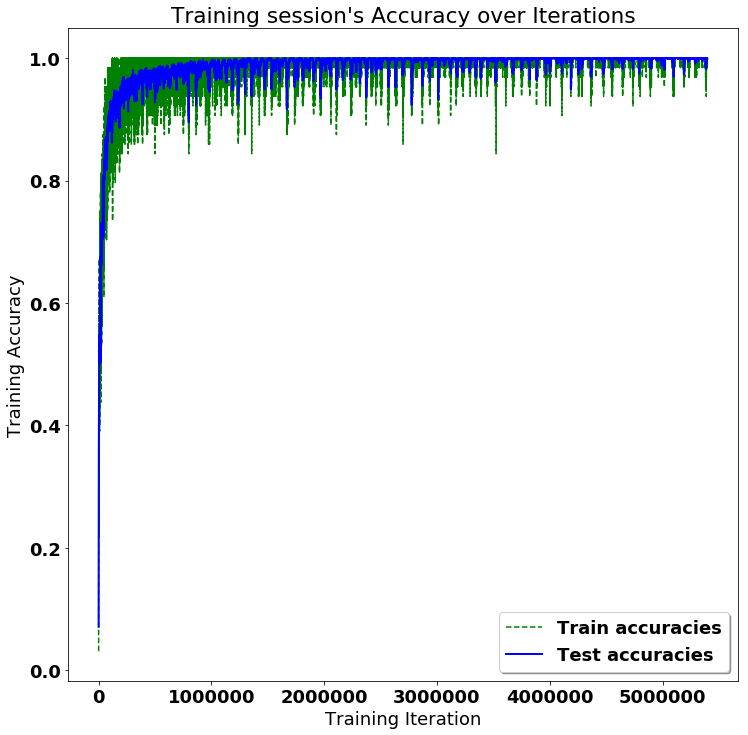

Testing Accuracy: 100.0%

Precision: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
Created using test set of 5270 datapoints, normalised to % of each class in the test dataset


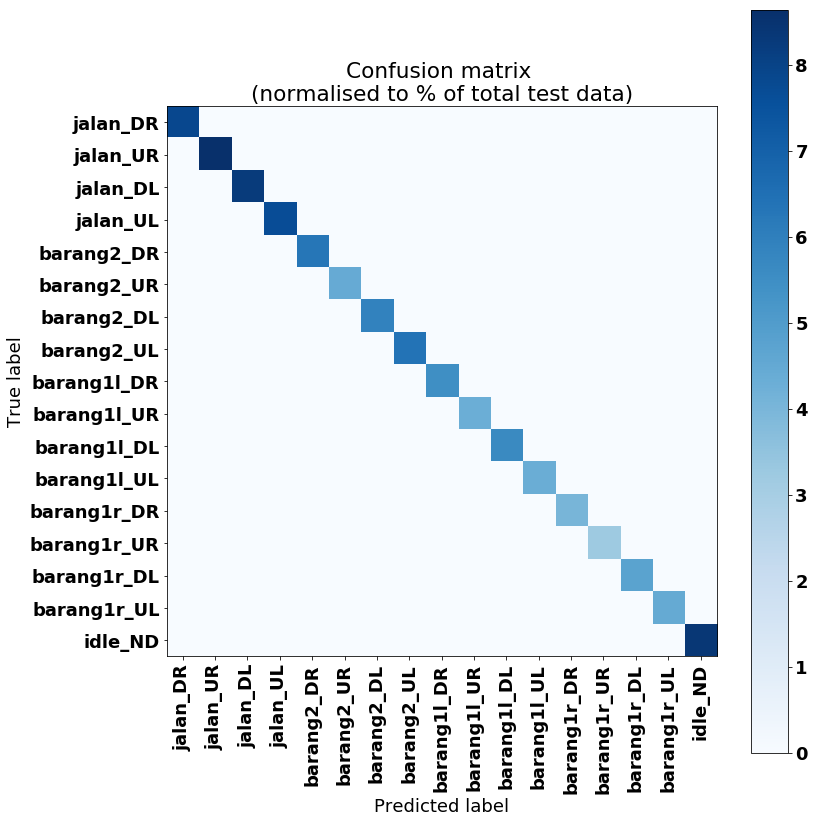

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.07096774, 0.23567362, 0.2593928, 0.34459203, 0.38311195, 0.42428842, 0.4426945, 0.45294118, 0.45180267, 0.4850095, 0.49411765, 0.4960152, 0.5091082, 0.5176471, 0.528463, 0.5480076, 0.5335863, 0.5398482, 0.5009488, 0.5225806, 0.57457304, 0.60740036, 0.60455406, 0.60493356, 0.60056925, 0.62827325, 0.61745733, 0.59924096, 0.6142315, 0.63681215, 0.61271346, 0.61973435, 0.6675522, 0.65275145, 0.67666036, 0.66413665, 0.63662237, 0.5037951, 0.62296015, 0.63263756, 0.62903225, 0.6886148, 0.7011385, 0.7039848, 0.713852, 0.7036053, 0.7102467, 0.7318786, 0.68557876, 0.69905126, 0.686148, 0.6836812, 0.66356736, 0.69411767, 0.69411767, 0.6867173, 0.6814042, 0.670019, 0.6629981, 0.69089186, 0.716129, 0.70512336, 0.71404177, 0.7024668, 0.7170778, 0.71366227, 0.7311196, 0.7204934, 0.7521822, 0.7552182, 0.754649, 0.78463, 0.801518, 0.7946869, 0.7686907, 0.7683112, 0.7631879, 0.771537, 0.7538899, 0.7622391, 0.7850095, 0.7664137, 0.7759013, 0.786907, 0.7886148, 0.80056924, 0.8104364, 0.7848197, 0.7939

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
